In [2710]:
import pandas as pd
import requests
from io import StringIO
from datetime import datetime
import time
from time import sleep
import random  
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score  # Ensure r2_score is imported
from scipy.stats import shapiro, probplot
from scipy.stats import skew
import scikit_posthocs as sp



## Extract data

### List of companies

In [ ]:
# Fetch the table with S&P 500 company data from Wikipedia 2025
url_sp500 = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
df_sp500 = pd.read_html(url_sp500)[0]  # The [0] selects the first table from the page
df_sp500.to_csv("sp500_empresas.csv", index=False)
print("Datos guardados en 'sp500_empresas.csv'")

In [504]:
# Fetch the table with S&P 500 company data from Wikipedia 2014
url_sp500_2014 = 'https://web.archive.org/web/20140623031208/https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
df_sp500_2014 = pd.read_html(url_sp500_2014)[1]  
df_sp500_2014.to_csv("sp500_empresas_2014.csv", index=False)
print("Datos guardados en 'sp500_empresas_2014.csv'")

Datos guardados en 'sp500_empresas_2014.csv'


In [2714]:
df_sp500 = pd.read_csv("sp500_empresas.csv")
df_sp500_2014 = pd.read_csv("sp500_empresas_2014.csv")

columns_to_keep = ["Ticker symbol"] 
df_sp500_2014_filtered = df_sp500_2014[columns_to_keep]

df_sp500_combined = pd.merge(df_sp500, df_sp500_2014_filtered, left_on='Symbol', right_on='Ticker symbol', how='left', suffixes=('_2025', '_2014'))
df_sp500_combined["is_in_sp500_2014"] = np.where(df_sp500_combined["Ticker symbol"].notna(), 1, 0)
df_sp500_combined.drop(columns=["Ticker symbol"], inplace=True)
df_sp500_combined.to_csv("df_sp500_combined.csv", index=False)
print("Datos guardados en 'df_sp500_combined.csv'")

Datos guardados en 'df_sp500_combined.csv'


In [2716]:
# Leemos el archivo CSV y lo convertimos en un DataFrame
df_sp500 = pd.read_csv("df_sp500_combined.csv")
print(df_sp500.shape)
df_sp500.head()

(503, 9)


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,is_in_sp500_2014
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902,1
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916,0
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888,1
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888),1
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989,1


### Financial indicators

In [ ]:
# OJO TARDA 2-3 HORAS EN EJECUTARSE
# Function to convert monetary values with suffixes B, M, K to float
def convert_to_float(value):
    if isinstance(value, str):
        value = value.replace('$', '').replace(',', '')  # Remove dollar signs and commas
        if 'B' in value:
            return float(value.replace('B', '').strip()) * 1e9  # Convert billions
        elif 'M' in value:
            return float(value.replace('M', '').strip()) * 1e6  # Convert millions
        elif 'K' in value:
            return float(value.replace('K', '').strip()) * 1e3  # Convert thousands
        else:
            return float(value)  # If no suffix, just convert to float
    return value

# Function to fetch P/E Ratio data
def get_pe_ratio_data(ticker, security_name):
    url_pe = f'https://www.macrotrends.net/stocks/charts/{ticker}/{security_name.lower().replace(" ", "-")}/pe-ratio'
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    attempt = 0
    while attempt < 5:  # Retry logic: try up to 5 times
        response_pe = requests.get(url_pe, headers=headers)
        
        if response_pe.status_code == 200:
            # Use StringIO to handle the HTML as a file-like object
            data_pe = pd.read_html(StringIO(response_pe.text))
            df_pe = pd.DataFrame(data_pe[0])
            df_pe.columns = ['Date', 'Stock Price', 'EPS', 'PE ratio']
            df_pe = df_pe.dropna()
            df_pe['Stock Price'] = df_pe['Stock Price'].replace(r'[\$,]', '', regex=True).astype(float)  # Escape $
            df_pe['EPS'] = df_pe['EPS'].replace(r'[\$,]', '', regex=True).astype(float)  # Escape $
            df_pe['PE ratio'] = df_pe['PE ratio'].astype(float)
            df_pe['Date'] = pd.to_datetime(df_pe['Date'], errors='coerce')  
            return df_pe
        elif response_pe.status_code == 429:
            print(f"Rate limit hit for P/E Ratio data for {ticker}, retrying...")
            attempt += 1
            sleep_time = random.uniform(10, 20)  # Random delay between 10 and 20 seconds
            print(f"Waiting for {sleep_time:.2f} seconds before retry...")
            time.sleep(sleep_time)
        else:
            print(f"Failed to fetch P/E Ratio data for {ticker} with status code {response_pe.status_code}")
            return None
    return None  # Return None if retries are exhausted

# Function to fetch Debt to Equity Ratio data
def get_debt_to_equity_data(ticker, security_name):
    url_de = f'https://www.macrotrends.net/stocks/charts/{ticker}/{security_name.lower().replace(" ", "-")}/debt-equity-ratio'
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    attempt = 0
    while attempt < 5:  # Retry logic: try up to 5 times
        response_de = requests.get(url_de, headers=headers)

        if response_de.status_code == 200:
            # Use StringIO to handle the HTML as a file-like object
            data_de = pd.read_html(StringIO(response_de.text))
            df_de = pd.DataFrame(data_de[0])
            df_de.columns = ['Date', 'Total Debt', "Shareholder's Equity", 'Debt to Equity Ratio']
            df_de = df_de.dropna()
            df_de['Total Debt'] = df_de['Total Debt'].apply(convert_to_float)
            df_de["Shareholder's Equity"] = df_de["Shareholder's Equity"].apply(convert_to_float)
            df_de['Debt to Equity Ratio'] = df_de['Debt to Equity Ratio'].astype(float)
            df_de['Date'] = pd.to_datetime(df_de['Date'], errors='coerce')  
            return df_de
        elif response_de.status_code == 429:
            print(f"Rate limit hit for Debt to Equity Ratio data for {ticker}, retrying...")
            attempt += 1
            sleep_time = random.uniform(10, 20)  # Random delay between 10 and 20 seconds
            print(f"Waiting for {sleep_time:.2f} seconds before retry...")
            time.sleep(sleep_time)
        else:
            print(f"Failed to fetch Debt to Equity Ratio data for {ticker}")
            return None
    return None  # Return None if retries are exhausted

# Function to fetch ROE data
def get_roe_ratio_data(ticker, security_name):
    url_roe = f'https://www.macrotrends.net/stocks/charts/{ticker}/{security_name.lower().replace(" ", "-")}/roe'
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    attempt = 0
    while attempt < 5:  # Retry logic: try up to 5 times
        response_roe = requests.get(url_roe, headers=headers)
        
        if response_roe.status_code == 200:
            # Use StringIO to handle the HTML as a file-like object
            data_roe = pd.read_html(StringIO(response_roe.text))
            df_roe = pd.DataFrame(data_roe[0])
            df_roe.columns = ['Date', 'Net Income', "Shareholder's Equity", 'Return on Equity']
            df_roe = df_roe.dropna()
            df_roe['Net Income'] = df_roe['Net Income'].apply(convert_to_float)
            df_roe["Shareholder's Equity"] = df_roe["Shareholder's Equity"].apply(convert_to_float)
            # Remove the percentage sign and convert to float, then optionally divide by 100 to convert to decimal
            df_roe['Return on Equity'] = df_roe['Return on Equity'].str.replace('%', '').astype(float) / 100
            df_roe['Return on Equity'] = df_roe['Return on Equity'].astype(float)
            df_roe['Calculated ROE'] = df_roe['Net Income'] / df_roe["Shareholder's Equity"]
            df_roe['Calculated ROE']=df_roe['Calculated ROE'].astype(float)            
            df_roe['Date'] = pd.to_datetime(df_roe['Date'], errors='coerce') 
            return df_roe
        elif response_roe.status_code == 429:
            print(f"Rate limit hit for ROE data for {ticker}, retrying...")
            attempt += 1
            sleep_time = random.uniform(10, 20)  # Random delay between 10 and 20 seconds
            print(f"Waiting for {sleep_time:.2f} seconds before retry...")
            time.sleep(sleep_time)
        else:
            print(f"Failed to fetch ROE data for {ticker} with status code {response_pe.status_code}")
            return None
    return None  # Return None if retries are exhausted

# Collect data for companies from S&P 500
company_data = []

start_date = pd.to_datetime('2014-01-01')

for i, row in df_sp500.iterrows(): 
    ticker = row['Symbol']
    security_name = row['Security']  # Using the 'Security' column for the company name
    sector = row['GICS Sector']  # Fetch the sector from the 'GICS Sector' column
    sector_sub = row['GICS Sub-Industry']    
    date_added = row['Date added']    
    founded = row['Founded']    
    
    # Fetch P/E Ratio data
    df_pe = get_pe_ratio_data(ticker, security_name)
    if df_pe is not None:
        time.sleep(random.uniform(5, 10))  # Random delay between 5 and 10 seconds
    
    # Fetch Debt to Equity Ratio data
    df_de = get_debt_to_equity_data(ticker, security_name)
    if df_de is not None:
        time.sleep(random.uniform(5, 10))  # Random delay between 5 and 10 seconds

    # Fetch ROE data
    df_roe = get_roe_ratio_data(ticker, security_name)
    if df_roe is not None:
        time.sleep(random.uniform(5, 10))  # Random delay between 5 and 10 seconds
    
    if df_pe is not None and df_de is not None and df_roe is not None:
        # Filter by date from 2014 onward
        df_pe = df_pe[df_pe['Date'] >= start_date]
        df_de = df_de[df_de['Date'] >= start_date]
        df_roe = df_roe[df_roe['Date'] >= start_date]
        
        # Merge the data
        df_combined = pd.merge(df_pe, df_de, on='Date', how='outer')
        df_combined = pd.merge(df_combined, df_roe, on='Date', how='outer')
        df_combined['Ticker'] = ticker
        df_combined['Security'] = security_name
        df_combined['Sector'] = sector  
        df_combined['date_added'] = date_added
        df_combined['founded'] = founded
        
        # Create new columns for year, quarter, and year-quarter combination
        df_combined['Year'] = df_combined['Date'].dt.year
        df_combined['Quarter'] = df_combined['Date'].dt.quarter
        df_combined['Year-Quarter'] = df_combined['Year'].astype(str) + '-Q' + df_combined['Quarter'].astype(str)
        
        # Add data for the current company
        company_data.append(df_combined)

# Combine all data into a single DataFrame
df_all = pd.concat(company_data, ignore_index=True)

# Sort by date
df_all = df_all.sort_values(by='Date')

# Save to CSV file
df_all.to_csv('sp500_companies_financial_data.csv', index=False)

print("Data has been saved to 'sp500_companies_financial_data.csv'.")


### Divident data

In [ ]:
# Extract the tickers (stock symbols)
tickers = df_sp500['Symbol'].tolist()

all_dividends = pd.DataFrame()

# Function to get dividend data from Yahoo Finance
def get_dividend_data(ticker):
    try:
        stock = yf.Ticker(ticker)
        dividend_data = stock.dividends
        df_dividends = dividend_data.reset_index()
        df_dividends.columns = ['Date', 'Dividend_Yield']
        df_dividends['Date'] = pd.to_datetime(df_dividends['Date'])
        
        # Remove timezone info
        df_dividends['Date'] = df_dividends['Date'].dt.tz_localize(None)
        
        # Filter data from January 1, 2014
        start_date = pd.to_datetime('2014-01-01')
        df_dividends = df_dividends[df_dividends['Date'] >= start_date]

        df_dividends['Ticker'] = ticker
        df_dividends['Year_Quarter'] = df_dividends['Date'].dt.to_period('Q')
        df_dividends_quarterly = df_dividends.groupby(['Ticker', 'Year_Quarter'])['Dividend_Yield'].sum().reset_index()

        return df_dividends_quarterly

    except Exception as e:
        print(f"Error retrieving dividends for {ticker}: {e}")
        return None

# Process each S&P 500 company
for ticker in tickers:
    print(f"Fetching dividend data for {ticker}...")

    df_dividends = get_dividend_data(ticker)

    if df_dividends is not None:
        all_dividends = pd.concat([all_dividends, df_dividends], ignore_index=True)
    time.sleep(2)

all_dividends.to_csv("sp500_dividends.csv", index=False)
print("All dividend data saved in 'sp500_dividends.csv'")

In [79]:
all_dividends = pd.read_csv("sp500_dividends.csv")
all_dividends['Year-Quarter'] = all_dividends['Year_Quarter'].str.replace(r'(\d{4})Q(\d)', r'\1-Q\2', regex=True)
all_dividends = all_dividends.drop('Year_Quarter', axis=1)
all_dividends

,Ticker,Dividend_Yield,Year-Quarter
0,MMM,0.714883,2014-Q1
1,MMM,0.714883,2014-Q2
2,MMM,0.714883,2014-Q3
3,MMM,0.714883,2014-Q4
4,MMM,0.857023,2015-Q1
...,...,...,...
16337,ZTS,0.432000,2024-Q1
16338,ZTS,0.432000,2024-Q2
16339,ZTS,0.432000,2024-Q3
16340,ZTS,0.432000,2024-Q4


## Transform data 

In [2718]:
df_financials = pd.read_csv("sp500_companies_financial_data.csv")
print(df_financials.isnull().sum())

Date                        0
Stock Price               558
EPS                       558
PE ratio                  558
Total Debt                  9
Shareholder's Equity_x      9
Debt to Equity Ratio        9
Net Income                202
Shareholder's Equity_y    202
Return on Equity          202
Calculated ROE            202
Ticker                      0
Security                    0
Sector                      0
date_added                  0
founded                     0
Year                        0
Quarter                     0
Year-Quarter                0
dtype: int64


In [2720]:
tickers_all_missing = []  # No "Stock Price" at all
tickers_first_quarters_missing = []  # "Stock Price" missing at the start but appears later
tickers_with_gaps = []  # "Stock Price" missing in the middle but present at the beginning
tickers_complete = []  # All "Stock Price" data

for ticker in df_financials['Ticker'].unique():
    df_ticker = df_financials[df_financials['Ticker'] == ticker].reset_index(drop=True)
    
    total_quarters = len(df_ticker)  
    null_count = df_ticker['Stock Price'].isna().sum()  # Number NaN in Stock Price
    
    if null_count == total_quarters:
        tickers_all_missing.append(ticker)  # No "Stock Price" at all
    elif null_count == 0:
        tickers_complete.append(ticker)  # All "Stock Price" data
    else:
        first_valid_index = df_ticker['Stock Price'].first_valid_index()
        
        if first_valid_index is not None and first_valid_index > 0:
            tickers_first_quarters_missing.append(ticker)  # "Stock Price" missing at the start but appears later
        else:
            tickers_with_gaps.append(ticker)  # "Stock Price" missing at the start but appears later
                
# Print results
print("Tickers with all missing stock prices:")
print(tickers_all_missing)

print("\nTickers with some missing stock prices (gaps in between):")
print(tickers_with_gaps)

print("\nTickers with missing stock prices only in the first quarters:")
print(tickers_first_quarters_missing)

print("\nTickers with all stock prices:")
print(tickers_complete)

Tickers with all missing stock prices:
['SW', 'GEV', 'SOLV']

Tickers with some missing stock prices (gaps in between):
['DLTR', 'ADI', 'ULTA', 'NDSN', 'GPN', 'JBL', 'CCL', 'STZ', 'DRI', 'MAR', 'NEE', 'ADP', 'BDX', 'BKR', 'BALL', 'BAC', 'AVY', 'SMCI', 'PFG', 'PCG', 'NXPI', 'NRG', 'OKE', 'PFE', 'AWK', 'DIS', 'GILD', 'CLX', 'WRB', 'CPT', 'HST', 'HSIC', 'CBOE', 'INTC', 'STX']

Tickers with missing stock prices only in the first quarters:
['DELL', 'KEYS', 'LDOS', 'WTW', 'ANET', 'MTCH', 'GOOG', 'SYF', 'AMCR', 'RVTY', 'ALLE', 'PYPL', 'PAYC', 'LHX', 'GDDY', 'CFG', 'EXR', 'ES', 'DD', 'CZR', 'KHC', 'TT', 'HUBB', 'HWM', 'HLT', 'SPGI', 'LW', 'HPE', 'VST', 'IR', 'INVH', 'FTV', 'DAY', 'UBER', 'DOW', 'MRNA', 'FOX', 'FOXA', 'CARR', 'CTVA', 'ABNB', 'CRWD', 'VICI', 'PLTR', 'OTIS', 'CEG', 'GEHC', 'KVUE', 'VLTO']

Tickers with all stock prices:
['TGT', 'ADSK', 'CSCO', 'DE', 'WMT', 'PANW', 'INTU', 'BBY', 'ROST', 'MDT', 'A', 'CPRT', 'SNPS', 'COO', 'CPB', 'BF.B', 'KR', 'AVGO', 'TJX', 'LULU', 'HRL', 'AMAT', 

In [2722]:
df_financials = df_financials[~df_financials['Ticker'].isin(tickers_all_missing)]
df_financials = df_financials[df_financials['Ticker'] != 'CBOE']
df_financials = df_financials[df_financials['Ticker'] != 'VLTO']

df_financials = df_financials[
    ~((df_financials['Ticker'] == 'GPN') & (df_financials['Date'] < '2016-12-31'))
] 

print(df_financials.isnull().sum())

Date                        0
Stock Price               464
EPS                       464
PE ratio                  464
Total Debt                  7
Shareholder's Equity_x      7
Debt to Equity Ratio        7
Net Income                162
Shareholder's Equity_y    162
Return on Equity          162
Calculated ROE            162
Ticker                      0
Security                    0
Sector                      0
date_added                  0
founded                     0
Year                        0
Quarter                     0
Year-Quarter                0
dtype: int64


In [2724]:
df_financials = df_financials.sort_values(by=['Ticker', 'Date'])

def remove_first_missing_stock_price(group):
    # 'tickers_first_quarters_missing'
    if group['Ticker'].iloc[0] in tickers_first_quarters_missing:
        # index of first 'Stock Price'
        first_valid_index = group['Stock Price'].first_valid_index()
        
        if first_valid_index is not None and first_valid_index > 0:
            # only stayed rows after first 'Stock Price'
            group = group.loc[first_valid_index:].reset_index(drop=True)
    
    return group

df_financials = df_financials.groupby('Ticker', group_keys=False).apply(remove_first_missing_stock_price).reset_index(drop=True)
print(df_financials.isnull().sum())

Date                       0
Stock Price               46
EPS                       46
PE ratio                  46
Total Debt                 7
Shareholder's Equity_x     7
Debt to Equity Ratio       7
Net Income                24
Shareholder's Equity_y    24
Return on Equity          24
Calculated ROE            24
Ticker                     0
Security                   0
Sector                     0
date_added                 0
founded                    0
Year                       0
Quarter                    0
Year-Quarter               0
dtype: int64


C:\Users\lasso\AppData\Local\Temp\ipykernel_17744\1224390609.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_financials = df_financials.groupby('Ticker', group_keys=False).apply(remove_first_missing_stock_price).reset_index(drop=True)


In [2726]:
# Sort by 'Ticker' and 'Year-Quarter' to correctly use shift()
df_financials = df_financials.sort_values(by=['Ticker', 'Year-Quarter'])

# Function to fill missing values by using the previous quarters' data
def fill_missing_values_with_previous(df, column_name, max_shifts=3):
    # Sequentially use shift() to fill NaN values
    for shift in range(1, max_shifts + 1):
        df[column_name] = df[column_name].fillna(df.groupby('Ticker')[column_name].shift(shift))
    return df

# Fill missing values
for col in ['Stock Price', 'EPS', 'PE ratio', 'Total Debt',	"Shareholder's Equity_x",	'Debt to Equity Ratio', 'Net Income', "Shareholder's Equity_y", 'Return on Equity', 'Calculated ROE']:
    df_financials = fill_missing_values_with_previous(df_financials, col)

#founded 2019
df_financials = df_financials[
    ~((df_financials['Ticker'] == 'FOX') & (df_financials['Date'] < '2019-01-01'))
] 
df_financials = df_financials[
    ~((df_financials['Ticker'] == 'FOXA') & (df_financials['Date'] < '2019-01-01'))
] 

# Calculate 'Stock_Price_Prev_Quarter'
df_financials['Stock_Price_Prev_Quarter'] = df_financials.groupby('Ticker')['Stock Price'].shift(1)

# Fill remaining NaN values with 0
df_financials['Stock_Price_Prev_Quarter'] = df_financials['Stock_Price_Prev_Quarter'].fillna(0)

# Avoid division by zero when calculating the stock price change ratio
df_financials['Stock_Price_Change_Ratio'] = (
    df_financials['Stock Price'] / df_financials['Stock_Price_Prev_Quarter'].replace(0, np.nan)
) - 1
df_financials['Stock_Price_Change_Ratio'] = df_financials['Stock_Price_Change_Ratio'].fillna(0)

print(df_financials.head())  # Check the results
df_financials.to_csv("sp500_financials_cleaned.csv", index=False)
print(df_financials.shape)
print(df_financials.isnull().sum())

         Date  Stock Price   EPS  PE ratio    Total Debt  \
0  2014-01-31        38.42  2.18     17.63  5.190000e+09   
1  2014-04-30        35.79  2.11     16.96  5.400000e+09   
2  2014-07-31        37.24  2.05     18.16  4.740000e+09   
3  2014-10-31        36.79  1.47     25.02  5.510000e+09   
4  2015-01-31        34.86  1.10     31.69  3.280000e+09   

   Shareholder's Equity_x  Debt to Equity Ratio   Net Income  \
0            5.450000e+09                  0.95  740000000.0   
1            5.630000e+09                  0.96  710000000.0   
2            5.640000e+09                  0.84  690000000.0   
3            5.300000e+09                  1.04  500000000.0   
4            4.240000e+09                  0.77  370000000.0   

   Shareholder's Equity_y  Return on Equity  ...  Ticker  \
0            5.450000e+09            0.1421  ...       A   
1            5.630000e+09            0.1348  ...       A   
2            5.640000e+09            0.1258  ...       A   
3            5

In [2728]:
# --------------------------- MERGE STEP ---------------------------
# Merge with the dividends dataset using Ticker and Year_Quarter
df_merged = pd.merge(df_financials, all_dividends, on=['Ticker', 'Year-Quarter'], how='left')
df_merged['Dividend_Yield'] = df_merged['Dividend_Yield'].fillna(0)

# Calculate Dividend Yield (%)
df_merged['Dividend_Yield_Percent'] = df_merged['Dividend_Yield'] / df_merged['Stock Price']

# Calculate Total Return (Stock Price Growth + Dividend Yield %)
df_merged['Total_Return'] = df_merged['Stock_Price_Change_Ratio'] + df_merged['Dividend_Yield_Percent']

df_merged['Total_Return_Annualized'] = (1 + df_merged['Total_Return'])**4 - 1

df_merged.to_csv("sp500_financials_with_dividends.csv", index=False)
print("Data saved in 'sp500_financials_with_dividends.csv'")



Data saved in 'sp500_financials_with_dividends.csv'


In [2730]:
print(df_merged.shape)
print(df_merged.isnull().sum())

(20710, 25)
Date                        0
Stock Price                 0
EPS                         0
PE ratio                    0
Total Debt                  0
Shareholder's Equity_x      0
Debt to Equity Ratio        0
Net Income                  1
Shareholder's Equity_y      1
Return on Equity            1
Calculated ROE              1
Ticker                      0
Security                    0
Sector                      0
date_added                  0
founded                     0
Year                        0
Quarter                     0
Year-Quarter                0
Stock_Price_Prev_Quarter    0
Stock_Price_Change_Ratio    0
Dividend_Yield              0
Dividend_Yield_Percent      0
Total_Return                0
Total_Return_Annualized     0
dtype: int64


In [2732]:
# To keep only companies that are in both lists in 2014 and 2024
df_sp500 = df_sp500[(df_sp500['is_in_sp500_2014'] == 1)]
columns_to_keep = ["Symbol", "GICS Sub-Industry"]
df_sp500 = df_sp500[columns_to_keep]
# Merge df_merged with df_sp500
df_merged = pd.merge(
    df_merged, df_sp500, left_on='Ticker', right_on='Symbol',
    how="inner"
)

In [2734]:
# Because we don´t have previous price for 2014-Q1 and some missing reports for 2024-Q4
df = df_merged[(df_merged['Year-Quarter'] >= '2014-Q2') & (df_merged['Year-Quarter'] <= '2024-Q3')]

new_order = [
    'Year-Quarter', 'Year', 'Quarter', 'Ticker', 'Security', 'Sector', 'GICS Sub-Industry',  
    'Stock Price', 'Stock_Price_Prev_Quarter', 'Stock_Price_Change_Ratio',  
    'EPS', 'PE ratio', 'Total Debt', "Shareholder's Equity_x", 'Debt to Equity Ratio',  
    'Net Income', 'Return on Equity',   
    'Dividend_Yield', 'Dividend_Yield_Percent', 'Total_Return', 'Total_Return_Annualized',  
    'date_added', 'founded'
]

df = df[new_order]
df = df.rename(columns={
    'GICS Sub-Industry': 'Sub_Sector',
    'Stock Price': 'Price',
    'PE ratio': 'PE_Ratio',
    'Total Debt': 'Total_Debt',
    "Shareholder's Equity_x": 'Total_Equity',
    'Debt to Equity Ratio': 'Debt_to_Equity_Ratio',
    'Net Income': 'Net_Income',
    'Return on Equity': 'Return_on_Equity',
    'Dividend_Yield': 'Dividends',
    'date_added': 'Date_Added',
    'founded': 'Founded'
})

df['Dividend_Payer'] = df.groupby('Ticker')['Dividends'].transform(lambda x: 1 if x.sum() > 0 else 0)

# Calculate average P/E per industry per quarter
df['Industry_PE'] = df.groupby(['Sector', 'Year-Quarter'])['PE_Ratio'].transform('mean')

# Calculate P/E Growth relative to the industry
df['PE_vs_Industry'] = df['PE_Ratio'] / df['Industry_PE']

# Sort DataFrame by Ticker and Date
df = df.sort_values(by=['Ticker', 'Year-Quarter'])

# Shift forward by 3 and 5 years (12 and 20 quarters)
df['Year-Quarter_After_3Y'] = df.groupby('Ticker')['Year-Quarter'].shift(-12)
df['Year-Quarter_After_5Y'] = df.groupby('Ticker')['Year-Quarter'].shift(-20)

df['PE_ratio_After_3Y'] = df.groupby('Ticker')['PE_Ratio'].shift(-12)
df['PE_ratio_After_5Y'] = df.groupby('Ticker')['PE_Ratio'].shift(-20)

df['Price_After_3Y'] = df.groupby('Ticker')['Price'].shift(-12)  
df['Price_After_5Y'] = df.groupby('Ticker')['Price'].shift(-20)  

# Calculate price change over 3 and 5 years
df['Price_Change_After_3Y'] = df['Price_After_3Y'] / df['Price'] - 1 
df['Price_Change_After_5Y'] = df['Price_After_5Y'] / df['Price'] - 1 

# Sum dividends over 12 and 20 quarters (3 and 5 years)
df['Dividends_After_3Y'] = df.groupby('Ticker')['Dividends'].rolling(12, min_periods=1).sum().shift(-12).reset_index(level=0, drop=True)
df['Dividends_After_5Y'] = df.groupby('Ticker')['Dividends'].rolling(20, min_periods=1).sum().shift(-20).reset_index(level=0, drop=True)

# Div %
df['Dividend_Yield_After_3Y'] = df['Dividends_After_3Y'] / df['Price'] 
df['Dividend_Yield_After_5Y'] = df['Dividends_After_5Y'] / df['Price'] 

# Total_Return
# Total return after 3 and 5 years (including price change and dividends)
df['Total_Return_After_3Y'] = ((df['Price_After_3Y'] + df['Dividends_After_3Y']) / df['Price']) - 1
df['Total_Return_After_5Y'] = ((df['Price_After_5Y'] + df['Dividends_After_5Y']) / df['Price']) - 1

df['CAGR_3Y'] = ((df['Total_Return_After_3Y'] + 1) ** (1/3) - 1)*100
df['CAGR_5Y'] = ((df['Total_Return_After_5Y'] + 1) ** (1/5) - 1)*100

df.fillna(0, inplace=True)


# Define P/E ratio categories
bins = [0, 0.01, 10, 15, 25, 40, float('inf')]
labels = ['5_No Earnings (P/E = 0)', '0_Undervalued', '1_Moderately Undervalued', '2_Fairly Valued', '3_Expensive', '4_Highly Overpriced']
df['PE_Category'] = pd.cut(df['PE_Ratio'], bins=bins, labels=labels, right=False)


# Function for segmentation DE
def segment_debt_to_equity(de_ratio):
    if de_ratio < 0:
        return "Negative Equity"
    elif de_ratio <= 0.5:
        return "Very Low Leverage"
    elif de_ratio <= 1.5:
        return "Moderate Leverage"
    elif de_ratio <= 5.0:
        return "Highly Leveraged"
    else:
        return "Extremely Leveraged"

# Apply segmentation and add as a new column to the original df
df['D/E_Category'] = df['Debt_to_Equity_Ratio'].apply(segment_debt_to_equity)

# Function for segmentation ROE
def segment_roe(roe_value):
    if roe_value < 0:
        return 'Negative ROE (Unprofitable)'
    elif roe_value < 0.15:
        return 'Low but Positive ROE (Weak profitability)'
    elif roe_value < 0.25:
        return 'Moderate ROE (Sustainable profitability)'
    elif roe_value >= 0.25:
        return 'High ROE (Strong profitability)'
   
# Apply segmentation and add as a new column to the original df
df['ROE_Segment'] = df['Return_on_Equity'].apply(segment_roe)
df["Year-Quarter"] = pd.to_datetime(df["Year-Quarter"])

# Function for Value Investment Type
def investment_type(row):
    if (row['PE_Ratio'] > 0 and 
        row['PE_Ratio'] <= 25 and 
        row['PE_vs_Industry'] < 1 and 
        row['Return_on_Equity'] >= 0.15 and 
        row['Dividend_Payer'] == 1 and 
        row['Net_Income'] > 0 and 
        row['Debt_to_Equity_Ratio'] <= 1.5):  
        return 1
    else:
        return 0

# Apply new categorization logic
df['Value_Investing'] = df.apply(investment_type, axis=1)
df['Investment_Type'] = df['Value_Investing'].map({1: 'Value_Investing', 0: 'Not_Value_Investing'})

# Save updated file
df.to_csv("sp500_financials_with_investment_flag.csv", index=False)

df_3Y = df[df['Year-Quarter_After_3Y'] != 0]
df_5Y = df[df['Year-Quarter_After_5Y'] != 0]

# Display updated DataFrame with new columns
print(df.head())
df.to_csv("sp500_financials_with_dividends_after_3_5_years.csv", index=False)
df_3Y.to_csv("df_3Y.csv", index=False)
df_5Y.to_csv("df_5Y.csv", index=True)


C:\Users\lasso\AppData\Local\Temp\ipykernel_17744\658151140.py:107: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Year-Quarter"] = pd.to_datetime(df["Year-Quarter"])


  Year-Quarter  Year  Quarter Ticker              Security       Sector  \
1   2014-04-01  2014        2      A  Agilent Technologies  Health Care   
2   2014-07-01  2014        3      A  Agilent Technologies  Health Care   
3   2014-10-01  2014        4      A  Agilent Technologies  Health Care   
4   2015-01-01  2015        1      A  Agilent Technologies  Health Care   
5   2015-04-01  2015        2      A  Agilent Technologies  Health Care   

                       Sub_Sector  Price  Stock_Price_Prev_Quarter  \
1  Life Sciences Tools & Services  35.79                     38.42   
2  Life Sciences Tools & Services  37.24                     35.79   
3  Life Sciences Tools & Services  36.79                     37.24   
4  Life Sciences Tools & Services  34.86                     36.79   
5  Life Sciences Tools & Services  38.28                     34.86   

   Stock_Price_Change_Ratio  ...  Dividend_Yield_After_5Y  \
1                 -0.068454  ...                 0.067237   
2     

### df final info

In [2736]:
print(df.shape)
print(df.isnull().sum())
print(df.info())

(12987, 47)
Year-Quarter                0
Year                        0
Quarter                     0
Ticker                      0
Security                    0
Sector                      0
Sub_Sector                  0
Price                       0
Stock_Price_Prev_Quarter    0
Stock_Price_Change_Ratio    0
EPS                         0
PE_Ratio                    0
Total_Debt                  0
Total_Equity                0
Debt_to_Equity_Ratio        0
Net_Income                  0
Return_on_Equity            0
Dividends                   0
Dividend_Yield_Percent      0
Total_Return                0
Total_Return_Annualized     0
Date_Added                  0
Founded                     0
Dividend_Payer              0
Industry_PE                 0
PE_vs_Industry              0
Year-Quarter_After_3Y       0
Year-Quarter_After_5Y       0
PE_ratio_After_3Y           0
PE_ratio_After_5Y           0
Price_After_3Y              0
Price_After_5Y              0
Price_Change_After_3Y       

## Style and order

In [2919]:

custom_palette = ['#2b485f',   '#f09c47',  '#469ea0', '#f2a900', '#f7d67b' , '#73b2c2' ]

sns.set_palette(custom_palette)
sector_order = [
    "Information Technology", "Financials", "Consumer Discretionary",  "Health Care", "Communication Services",
     "Industrials", "Consumer Staples", "Energy" , "Real Estate", "Materials",  "Utilities"
    ]


## Análisis Exploratorio de Datos (EDA)

### Distribution of P/E Ratio

In [2700]:
df['PE_Ratio'].describe()

count    12987.000000
mean        28.229588
std        132.049277
min          0.000000
25%         11.585000
50%         17.810000
75%         26.395000
max      10188.270000
Name: PE_Ratio, dtype: float64

<Axes: xlabel='PE_Ratio', ylabel='Count'>

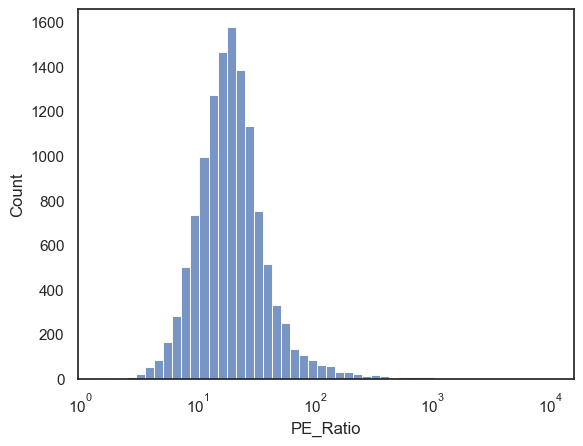

In [2702]:
# log_scale=True aplica la escala logarítmica al eje x 
sns.set(style="white")
sns.histplot(df['PE_Ratio'], bins=50, log_scale=True)

##### Distribution of P/E Ratio - Without outliers 

<Axes: xlabel='PE_Ratio', ylabel='Count'>

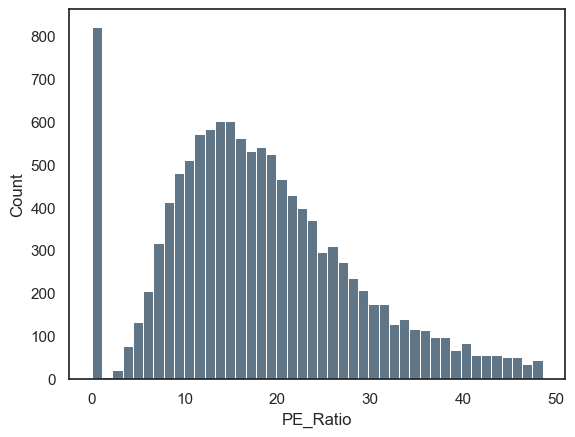

In [2595]:
Q1 = df['PE_Ratio'].quantile(0.25)
Q3 = df['PE_Ratio'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_IQR = df[(df['PE_Ratio'] >= lower_bound) & (df['PE_Ratio'] <= upper_bound)]
df_IQR = df_IQR.sort_values(by=['Year', 'Quarter'])

sns.histplot(df_IQR['PE_Ratio'])

##### Distribution of P/E Ratio by Sector

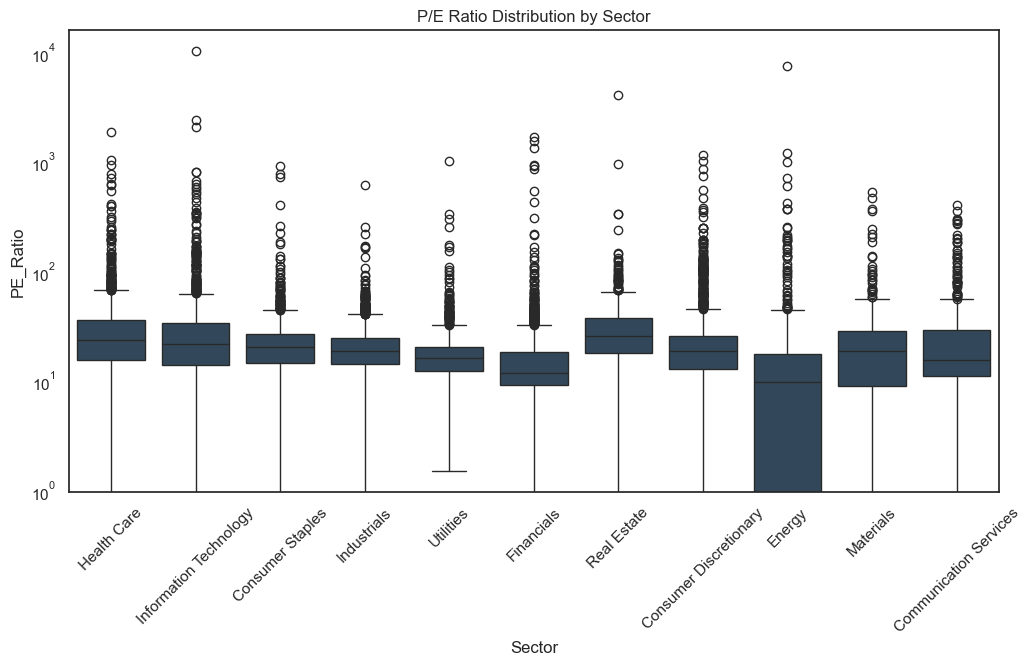

In [2593]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Sector', y='PE_Ratio' )
plt.xticks(rotation=45)
plt.yscale('log') 
plt.title('P/E Ratio Distribution by Sector')
plt.show()


##### Distribution of P/E Ratio by Sector - Without outliers 

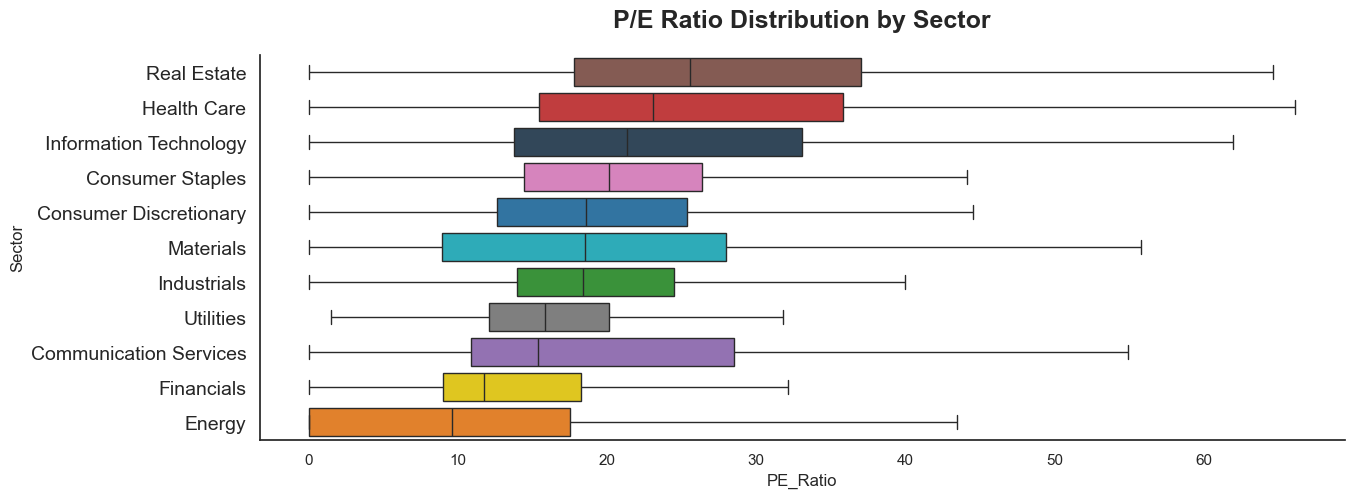

In [2911]:
sector_medians_pe = df.groupby("Sector")["PE_Ratio"].median().sort_values(ascending=False)
sector_order_pe = sector_medians_pe.index.tolist()

# Set the colors for each sector in the palette
sector_colors_pe = {
    "Information Technology": "#2b485f",  # Dark Blue
    "Financials": "#ffdd00",  # Bright Yellow (changed from red)
    "Consumer Discretionary": "#1f77b4",  # Blue
    "Health Care": "#d62728",  # Red
    "Communication Services": "#9467bd",  # Purple
    "Industrials": "#2ca02c",  # Green
    "Consumer Staples": "#e377c2",  # Pink
    "Energy": "#ff7f0e",  # Dark Orange
    "Real Estate": "#8c564b",  # Brown
    "Materials": "#17becf",  # Turquoise
    "Utilities": "#7f7f7f"  # Grey
}

sns.set_palette([sector_colors_pe[sector] for sector in sector_order_pe])

plt.figure(figsize=(14, 5))
sns.boxplot(
    data=df, 
    y="Sector", 
    x="PE_Ratio", 
    hue="Sector",
    order=sector_order_pe,  # Sort by PE ratio
    showfliers=False, 
    notch=False,
    palette=sector_colors_pe  # Explicitly set the color palette
)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks(rotation=0, fontsize=14)
plt.title("P/E Ratio Distribution by Sector",   pad=20, fontsize=18, fontweight='bold')
plt.show()


In [2742]:
print(sector_medians_pe)

Sector
Real Estate               25.540
Health Care               23.090
Information Technology    21.310
Consumer Staples          20.120
Consumer Discretionary    18.605
Materials                 18.520
Industrials               18.350
Utilities                 15.840
Communication Services    15.340
Financials                11.740
Energy                     9.580
Name: PE_Ratio, dtype: float64


### P/E Ratio Trend by Sector

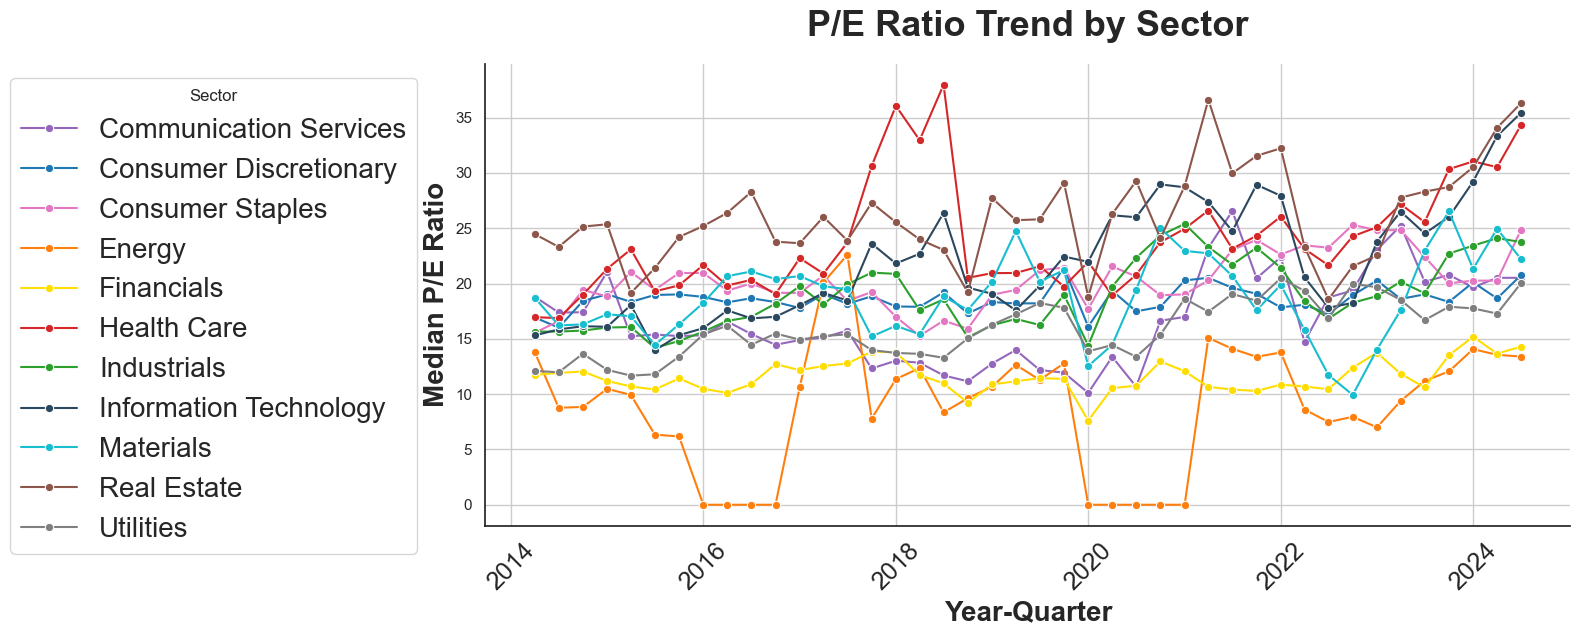

In [2915]:
pe_sector_trend = df.groupby(['Year-Quarter', 'Sector'])['PE_Ratio'].median().reset_index()
pe_sector_trend['Smoothed_PE_Ratio'] = pe_sector_trend.groupby('Sector')['PE_Ratio'].rolling(window=4, min_periods=1).mean().reset_index(level=0, drop=True)

plt.figure(figsize=(14, 6))
sns.lineplot(data=pe_sector_trend, x='Year-Quarter', y='PE_Ratio', hue='Sector',  marker='o', palette=sector_colors_pe )
plt.xlabel('Year-Quarter',   fontsize=20, fontweight='bold')
plt.ylabel('Median P/E Ratio',   fontsize=20, fontweight='bold')
plt.title('P/E Ratio Trend by Sector',   pad=20, fontsize=26, fontweight='bold')
plt.xticks(rotation=45, fontsize=18,)
plt.legend(title="Sector", bbox_to_anchor=(-0.05, 1),  fontsize=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True)
plt.show()


### Distribution of ROE

In [2430]:
df['Return_on_Equity'].describe()

count    12987.000000
mean         0.555085
std         22.244288
min       -652.320000
25%          0.084200
50%          0.151500
75%          0.281550
max       2165.000000
Name: Return_on_Equity, dtype: float64

<Axes: xlabel='Return_on_Equity', ylabel='Count'>

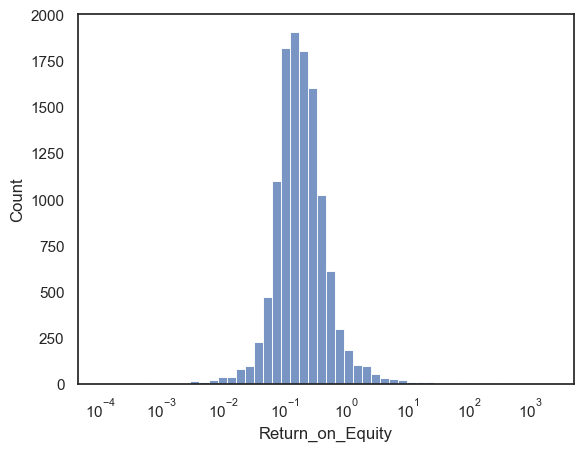

In [2432]:
# log_scale=True aplica la escala logarítmica al eje x 
sns.set(style="white")
#sns.color_palette("icefire", as_cmap=True)
sns.histplot(df['Return_on_Equity'], bins=50, log_scale=True)

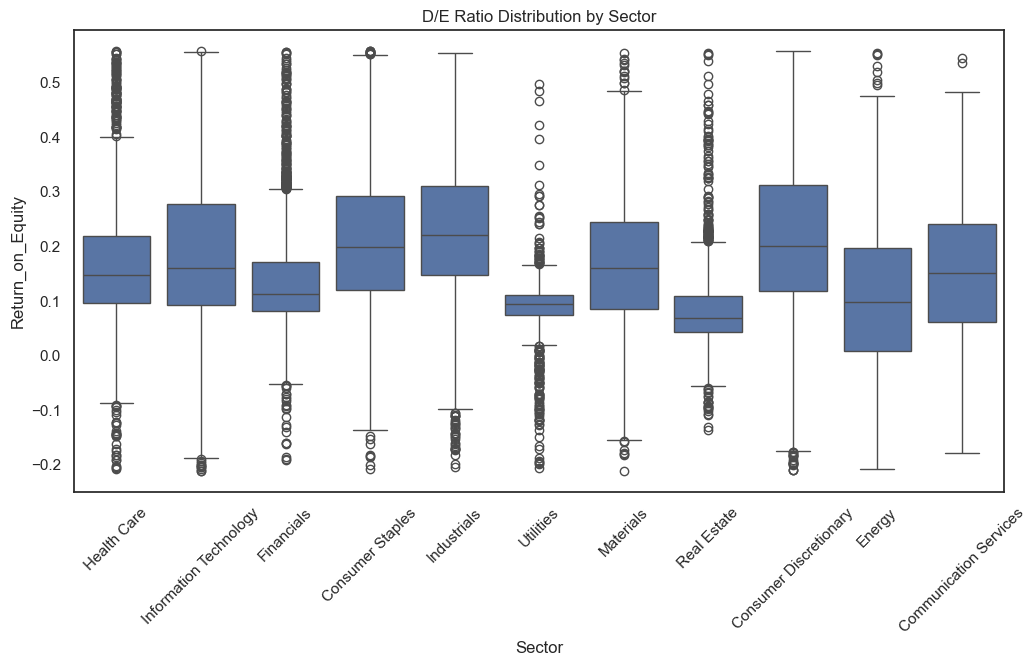

In [2434]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_IQR_roe, x='Sector', y='Return_on_Equity')
plt.xticks(rotation=45)
#plt.yscale('log') 
plt.title('D/E Ratio Distribution by Sector')
plt.show()


### Distribution of D/E Ratio

In [2438]:
df['Debt_to_Equity_Ratio'].describe()

count    12987.000000
mean         3.313232
std         70.461314
min      -2490.600000
25%          1.010000
50%          1.860000
75%          3.720000
max       6258.800000
Name: Debt_to_Equity_Ratio, dtype: float64

<Axes: xlabel='Debt_to_Equity_Ratio', ylabel='Count'>

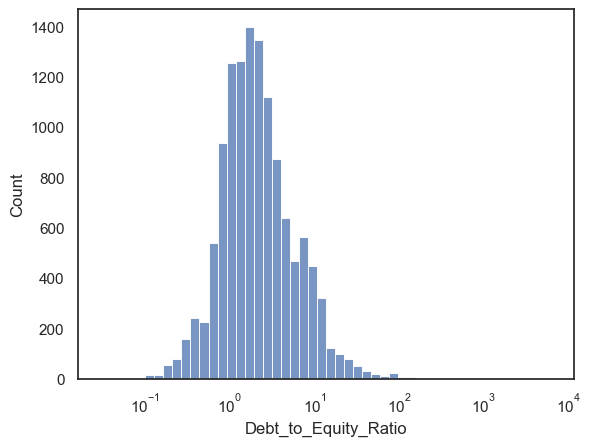

In [2440]:
# log_scale=True aplica la escala logarítmica al eje x 
sns.set(style="white")
#sns.color_palette("icefire", as_cmap=True)
sns.histplot(df['Debt_to_Equity_Ratio'], bins=50, log_scale=True)

## CAGR Compound annual growth rate

El **CAGR** (Tasa de Crecimiento Anual Compuesta) es una fórmula utilizada para calcular la tasa de crecimiento promedio anual de una inversión o activo durante un período determinado de tiempo, tomando en cuenta la capitalización compuesta. Es decir, muestra cuánto crece el valor de una inversión cada año, si el crecimiento fuera constante durante todo el período.

El CAGR es útil para comparar el rendimiento de diferentes activos (acciones, fondos, inversiones) a lo largo de un período. 
También es útil para evaluar el desempeño histórico de una empresa, acción o fondo de inversión, dado que proporciona una tasa de crecimiento consistente y elimina la volatilidad anual.

### df_5y

### 5-Year CAGR from 2014-Q2 to 2019-Q3

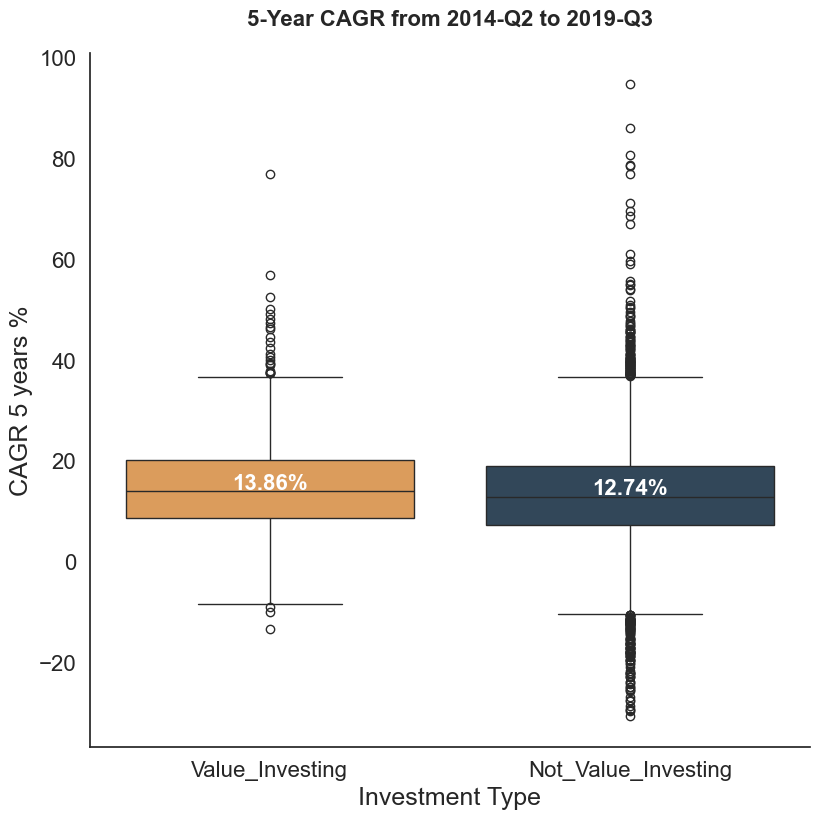

In [2937]:
plt.figure(figsize=(8, 8))
box_plot = sns.boxplot(data=df_5Y, x='Investment_Type', y='CAGR_5Y', 
                       hue='Investment_Type', order=['Value_Investing', 'Not_Value_Investing'], 
                       notch=False)

# Add labels just above the median values
medians = df_5Y.groupby('Investment_Type')["CAGR_5Y"].median()
for i, investment_type in enumerate(['Value_Investing', 'Not_Value_Investing']):
    median_value = medians[investment_type]
    box_plot.text(i, median_value + 0.5,  # Adjusted position slightly above median
                  f"{median_value:.2f}%", 
                  horizontalalignment='center', 
                  fontsize=16, color='white', fontweight='bold')

plt.xticks(rotation=0)
plt.title('5-Year CAGR from 2014-Q2 to 2019-Q3',  pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Investment Type', fontsize=18)
plt.ylabel('CAGR 5 years %', fontsize=18)
plt.xticks(rotation=0, fontsize=16)
plt.yticks(rotation=0, fontsize=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout(pad=0)
plt.show()


In [2478]:
from scipy.stats import mannwhitneyu
value_cagr = df_5Y[df_5Y["Investment_Type"] == "Value_Investing"]["CAGR_5Y"]
growth_cagr = df_5Y[df_5Y["Investment_Type"] == "Not_Value_Investing"]["CAGR_5Y"]
u_stat, p_value = mannwhitneyu(value_cagr, growth_cagr, alternative="two-sided")
print(f"U-statistic: {u_stat}, p-value: {p_value:.4f}")

U-statistic: 2571603.0, p-value: 0.0001


### Sector

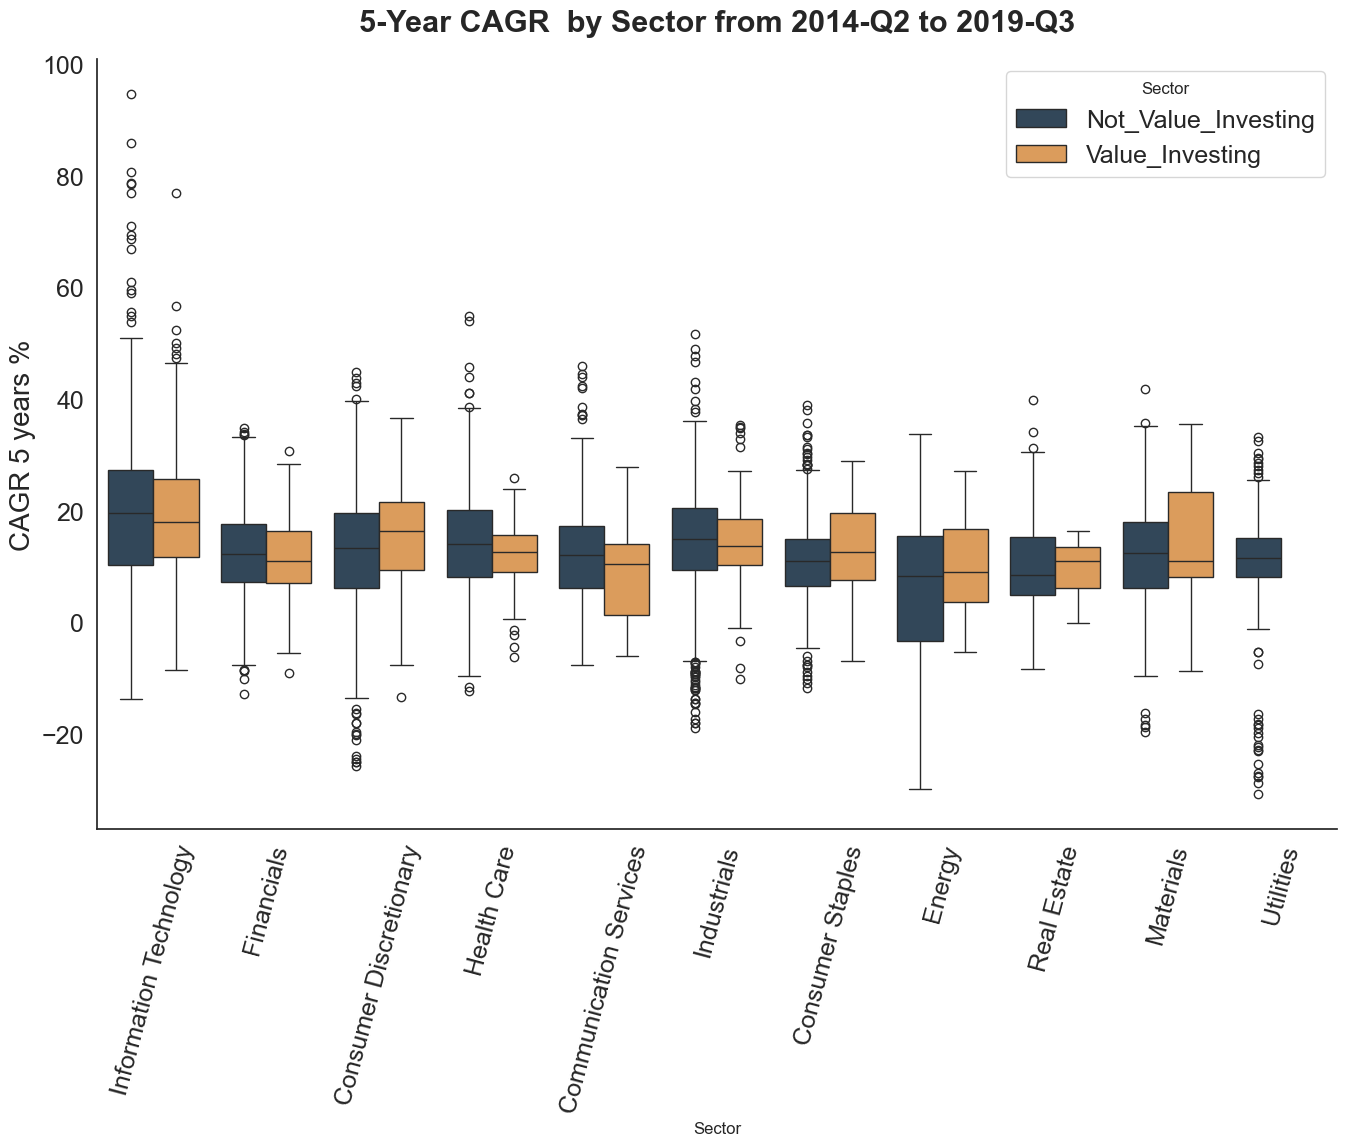

In [2961]:
# Boxplot visualization
plt.figure(figsize=(16, 10))
sns.boxplot(data=df_5Y, x="Sector",  y="CAGR_5Y", hue="Investment_Type", order=sector_order, showfliers=True, notch=False)
plt.xticks(rotation=90)
plt.title('5-Year CAGR  by Sector from 2014-Q2 to 2019-Q3',  fontsize=22, fontweight='bold', pad=20)
plt.ylabel('CAGR 5 years %', fontsize=20)
plt.xticks(rotation=75, fontsize=18)
plt.yticks(rotation=0, fontsize=18)
plt.legend(title="Sector", fontsize=18,  loc='upper right')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

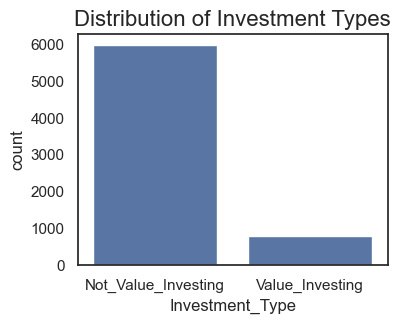

In [2814]:
plt.figure(figsize=(4, 3))
sns.countplot( data=df_5Y, x="Investment_Type")
plt.title("Distribution of Investment Types", fontsize=16)
plt.show()

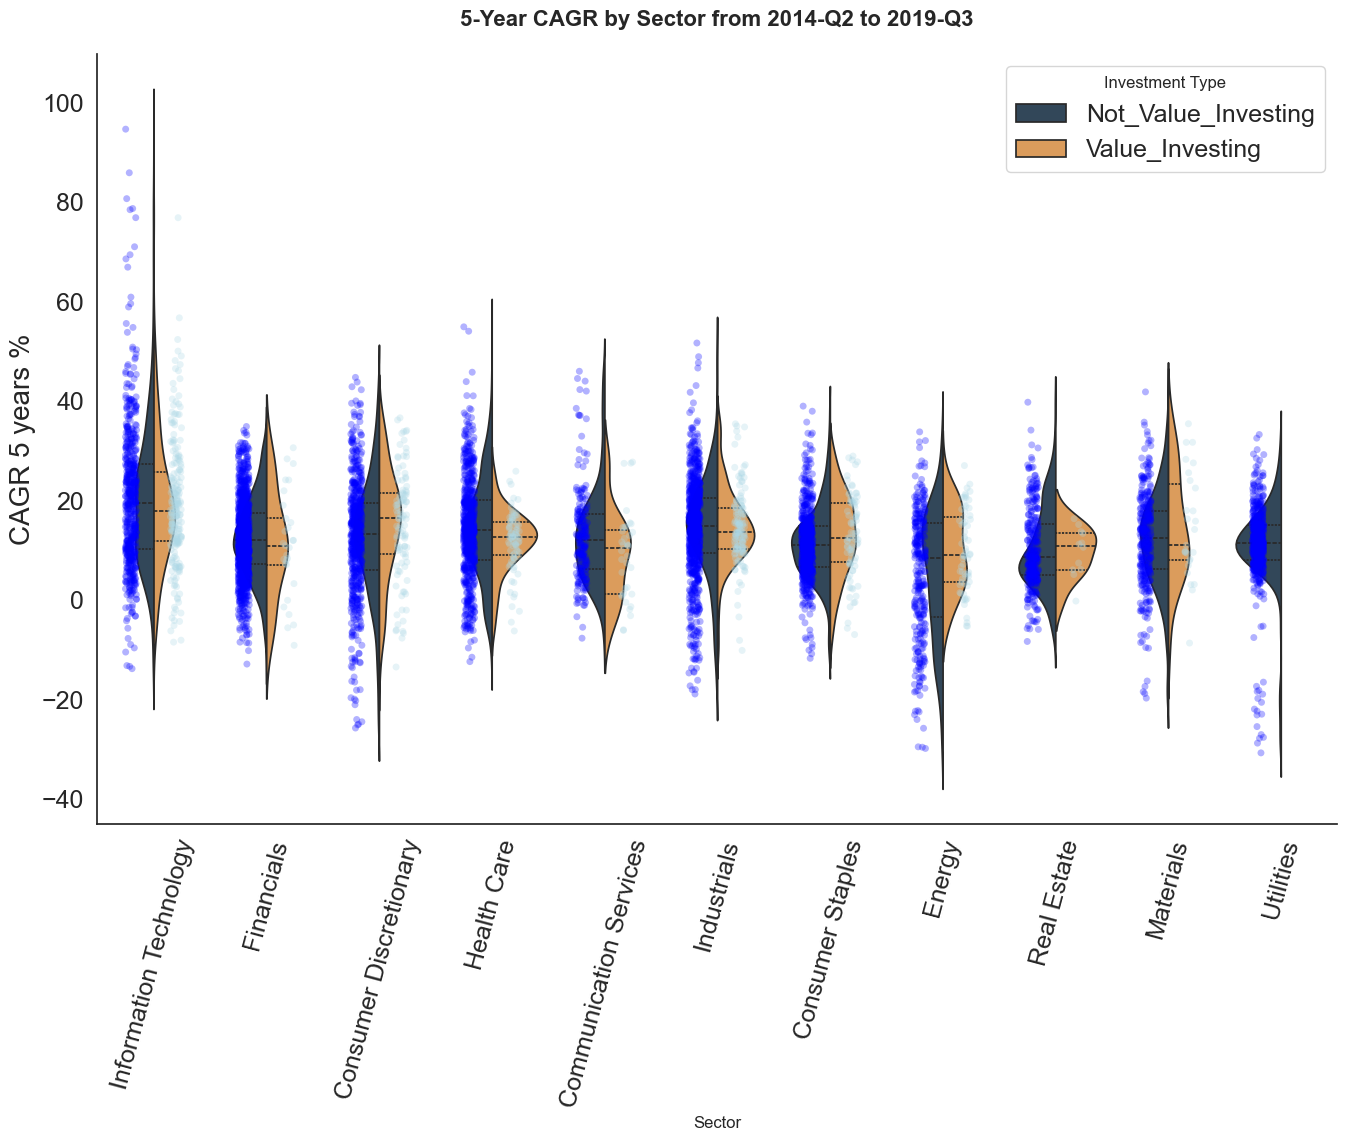

In [2975]:
# Violin plot with scatter plot overlay
plt.figure(figsize=(16, 10))

# Violin plot
sns.violinplot(data=df_5Y, x="Sector", y="CAGR_5Y", hue="Investment_Type", order=sector_order, split=True, inner="quartile")

# Scatter plot (stripplot)
sns.stripplot(data=df_5Y, x="Sector", y="CAGR_5Y", hue="Investment_Type", order=sector_order, dodge=True, jitter=True, palette=["blue", "lightblue"], alpha=0.3)

plt.xticks(rotation=90)
plt.title('5-Year CAGR by Sector from 2014-Q2 to 2019-Q3', fontsize=16, fontweight='bold', pad=20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(df_5Y["Investment_Type"].unique())], labels[:len(df_5Y["Investment_Type"].unique())], title="Investment Type",fontsize=18,)
plt.ylabel('CAGR 5 years %', fontsize=20)
plt.xticks(rotation=75, fontsize=18)
plt.yticks(rotation=0, fontsize=18)
plt.show()

In [2794]:
result = df_5Y.groupby(["Sector", "Investment_Type"]).size().unstack()
print(result)

Investment_Type         Not_Value_Investing  Value_Investing
Sector                                                      
Communication Services                207.0             36.0
Consumer Discretionary                601.0            103.0
Consumer Staples                      595.0             87.0
Energy                                310.0             64.0
Financials                           1027.0             29.0
Health Care                           644.0             82.0
Industrials                           840.0            134.0
Information Technology                595.0            219.0
Materials                             331.0             27.0
Real Estate                           296.0             12.0
Utilities                             528.0              NaN


Key observations:
Consumer Discretionary and Information Technology exhibit the highest average CAGR for both Value and Not Value Investing
Energy and Real Estate have the lowest CAGR values, with Value Investing showing slightly better performance
Financials and Materials show a decline in CAGR for Value Investing compared to Not Value Investing
For instance:
Utilities and Consumer Staples tend to have lower volatility
Technology and Consumer Discretionary remain high-growth but show increased variability

### Sector Analysis: P/E Ratio vs 5-Year CAGR

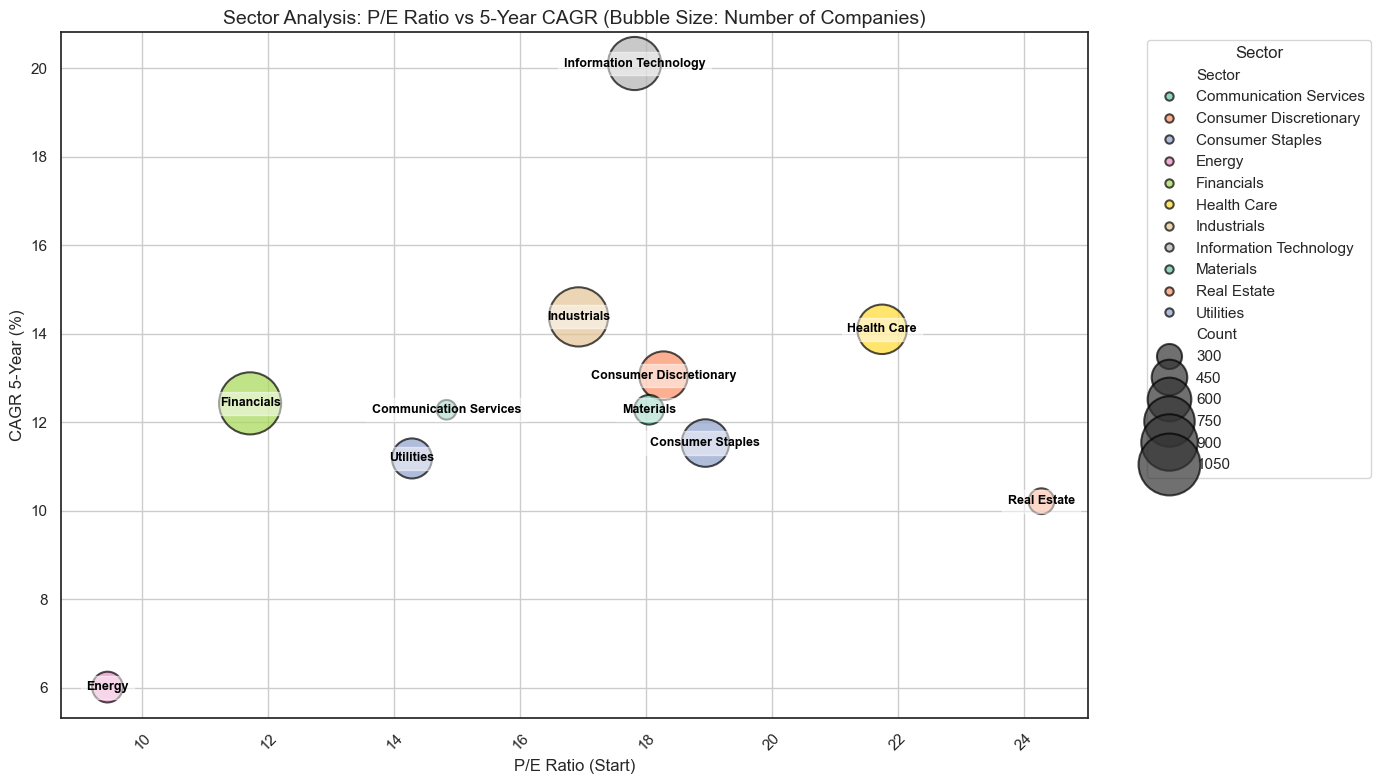

In [2603]:
# Grouping data for the bubble chart
df_grouped_5Y = df_5Y.groupby(['Sector']).agg(
    CAGR_5Y=('CAGR_5Y', 'mean'),
    Average_Dividend_Yield=('Dividend_Yield_Percent', 'mean'),
    PE_Ratio_Start=('PE_Ratio', 'median'),
    Count=('Ticker', 'count')
).reset_index()

# Create Bubble Chart with improved visualization
plt.figure(figsize=(14, 8))

# Scatterplot
sns.scatterplot(
    data=df_grouped_5Y, 
    x='PE_Ratio_Start', 
    y='CAGR_5Y', 
    size= 'Count',  # Bubble size corresponds to Dividend Yield
    hue='Sector', 
    palette='Set2', 
    sizes=(200, 2000),  # Adjusted sizes to improve visualization
    alpha=0.7, 
    edgecolor='black'
)

# Annotate each bubble with the sector name
for i in range(len(df_grouped_5Y)):
    plt.text(
        df_grouped_5Y['PE_Ratio_Start'].iloc[i], 
        df_grouped_5Y['CAGR_5Y'].iloc[i], 
        df_grouped_5Y['Sector'].iloc[i], 
        fontsize=9, ha='center', va='center', 
        fontweight='bold', color='black', 
        bbox=dict(facecolor='white', alpha=0.5)
    )
    

plt.title('Sector Analysis: P/E Ratio vs 5-Year CAGR (Bubble Size: Number of Companies)', fontsize=14)
plt.xlabel('P/E Ratio (Start)', fontsize=12)
plt.ylabel('CAGR 5-Year (%)', fontsize=12)
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1996]:
df_5Y.groupby("Investment_Type")["CAGR_5Y"].std()

Investment_Type
Not_Value_Investing    10.630052
Value_Investing        10.460758
Name: CAGR_5Y, dtype: float64

## Make df_10Y

In [2632]:
df['Year-Quarter'] = pd.to_datetime(df['Year'].astype(str) + '-Q' + df['Quarter'].astype(str))

# Count the number of zeros in 'PE_vs_Industry'
df['PE_vs_Industry_Zero_Count'] = df['PE_vs_Industry'].apply(lambda x: 1 if x == 0 else 0)
# Count the number of zeros in 'PE_vs_Industry'
df['PE_Ratio_Zero_Count'] = df['PE_Ratio'].apply(lambda x: 1 if x == 0 else 0)

# Grouping by Ticker, Security, and Sector
df_10y = df.groupby(['Ticker', 'Security', 'Sector']).agg({
    'Price': ['first', 'last'],
    'Stock_Price_Change_Ratio': 'std',
    'Year-Quarter': ['first', 'last'],
    'PE_Ratio': ['mean', 'median','std', 'first', 'last', 'max', 'min'],
    'PE_Ratio_Zero_Count': 'sum',  # Sum the number of zeros
    'PE_vs_Industry': ['mean'],  
    'PE_vs_Industry_Zero_Count': 'sum',  # Sum the number of zeros
    'Return_on_Equity': ['mean', 'first', 'last', 'std'],
    'Debt_to_Equity_Ratio': ['mean', 'first', 'last'],
    'Dividend_Yield_Percent': ['mean', 'std'],
    'Dividends': ['sum', 'std'],
}).reset_index()

# Rename columns
df_10y.columns = ['_'.join(col).strip('_') for col in df_10y.columns.values]
df_10y.rename(columns={
    'Price_first': 'Price_Start',
    'Price_last': 'Price_End',
    'Stock_Price_Change_Ratio_std': 'Price_Volatility',
    'Year-Quarter_first': 'Start_Date',
    'Year-Quarter_last': 'End_Date',
    'PE_Ratio_mean': 'PE_Ratio_Mean',
    'PE_Ratio_median': 'PE_Ratio_Median',
    'PE_Ratio_std': 'PE_Ratio_Std',
    'PE_Ratio_first': 'PE_Ratio_First',
    'PE_Ratio_last': 'PE_Ratio_Last',
    'PE_Ratio_max': 'PE_Ratio_Max',
    'PE_Ratio_min': 'PE_Ratio_Min',
    'PE_Ratio_Zero_Count_sum': 'PE_Ratio_Zero_Count',  # Renaming the zero count column
    'PE_vs_Industry_mean': 'PE_vs_Industry_Mean',
    'PE_vs_Industry_Zero_Count_sum': 'PE_vs_Industry_Zero_Count',  # Renaming the zero count column
    'Return_on_Equity_mean': 'ROE_Mean',
    'Return_on_Equity_first': 'ROE_First',
    'Return_on_Equity_last': 'ROE_Last',
    'Return_on_Equity_std': 'ROE_Std',
    'Debt_to_Equity_Ratio_mean': 'Debt_to_Equity_Mean',
    'Debt_to_Equity_Ratio_first': 'Debt_to_Equity_First',
    'Debt_to_Equity_Ratio_last': 'Debt_to_Equity_Last',
    'Dividends_sum': 'Total_Dividends',
    'Dividend_Yield_Percent_mean': 'Avg_Dividend_Yield', 
    'Dividend_Yield_Percent_std': 'Dividend_Stability',
    'Dividends_std': 'Dividend_Payout_Volatility'
}, inplace=True)

# Group by 'Ticker' and calculate the mean for 'PE_Ratio' excluding zeros within each group
df_10y['PE_Ratio_Mean_'] = df_10y.apply(
    lambda row: df[df['Ticker'] == row['Ticker']].loc[df['PE_Ratio'] != 0, 'PE_Ratio'].mean()
    if row['PE_Ratio_Zero_Count'] > 0 else row['PE_Ratio_Mean'],
    axis=1
)

# Group by 'Ticker' and calculate the mean for 'PE_vs_Industry' excluding zeros within each group
df_10y['PE_vs_Industry_Mean_Excluding_Zeros'] = df_10y.apply(
    lambda row: df[df['Ticker'] == row['Ticker']].loc[df['PE_vs_Industry'] != 0, 'PE_vs_Industry'].mean()
    if row['PE_vs_Industry_Zero_Count'] > 0 else row['PE_vs_Industry_Mean'],
    axis=1
)

# Calculate years in the dataset
df_10y['Years'] = (df_10y['End_Date'] - df_10y['Start_Date']).dt.days / 365.25

# Calculate CAGR for 10Y
df_10y['CAGR_10Y'] = ((df_10y['Price_End'] + df_10y['Total_Dividends']) / df_10y['Price_Start'])**(1 / df_10y['Years']) - 1
df_10y['CAGR_10Y_Percent'] = df_10y['CAGR_10Y'] * 100

# Identify dividend payers
df_10y['Dividend_Payer'] = df_10y['Total_Dividends'].apply(lambda x: '1' if x > 0 else '0')

# Calculate Dividend Yield
df_10y['Dividend_Yield'] = df_10y.apply(
    lambda row: (row['Total_Dividends'] / row['Price_Start']) * 100 if row['Total_Dividends'] > 0 else 0, 
    axis=1
)


# Calculate financial ratio changes
df_10y['PE_Ratio_Change'] = (df_10y['PE_Ratio_Last'] - df_10y['PE_Ratio_First']) / df_10y['PE_Ratio_First']
df_10y['ROE_Change'] = (df_10y['ROE_Last'] - df_10y['ROE_First']) / df_10y['ROE_First']
df_10y['Debt_to_Equity_Change'] = (df_10y['Debt_to_Equity_Last'] - df_10y['Debt_to_Equity_First']) / df_10y['Debt_to_Equity_First']

# Volatility and growth calculations
df_10y['PE_Ratio_Range'] = df_10y['PE_Ratio_Max'] - df_10y['PE_Ratio_Min']
df_10y['PE_Ratio_CV'] = df_10y['PE_Ratio_Std'] / df_10y['PE_Ratio_Mean']  # Coefficient of Variation
df_10y['ROE_Volatility'] = df_10y['ROE_Std'] / df_10y['ROE_Mean']

# Fix PE Growth formula
df_10y['PE_Growth'] = ((df_10y['PE_Ratio_Last'] / df_10y['PE_Ratio_First'])**(1 / df_10y['Years'])) - 1



# Fill remaining NaN values with 0
df_10y.fillna(0, inplace=True)

# Sort by CAGR_10Y
df_10y = df_10y.sort_values(by='CAGR_10Y', ascending=False)

#Volatility_Bin
bins = [0, 0.10, 0.13, 0.16, 0.22, np.inf]  
labels = ["Very Low", "Low", "Medium", "High", "Very High"]
df_10y['Volatility_Bin'] = pd.cut(df_10y['Price_Volatility'], bins=bins, labels=labels)
# Save to CSV
df_10y.to_csv("sp500_10y.csv", index=False)

C:\Users\lasso\AppData\Local\Temp\ipykernel_17744\1395217086.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Year-Quarter'] = pd.to_datetime(df['Year'].astype(str) + '-Q' + df['Quarter'].astype(str))


In [2263]:
print(df_10y.shape)
print(df_10y.isnull().sum())
print(df_10y.info())

(311, 43)
Ticker                                 0
Security                               0
Sector                                 0
Price_Start                            0
Price_End                              0
Price_Volatility                       0
Start_Date                             0
End_Date                               0
PE_Ratio_Mean                          0
PE_Ratio_Std                           0
PE_Ratio_First                         0
PE_Ratio_Last                          0
PE_Ratio_Max                           0
PE_Ratio_Min                           0
PE_Ratio_Zero_Count                    0
PE_vs_Industry_Mean                    0
PE_vs_Industry_Zero_Count              0
ROE_Mean                               0
ROE_First                              0
ROE_Last                               0
ROE_Std                                0
Debt_to_Equity_Mean                    0
Debt_to_Equity_First                   0
Debt_to_Equity_Last                    0
Avg_Di

### 10-Year CAGR by Sector: Box Plot with Benchmark Reference Lines

El gráfico de caja (box plot) se genera usando seaborn (sns.boxplot). Los sectores se muestran en el eje X, y el CAGR_Total_Return en el eje Y. Los valores atípicos se han ocultado (showfliers=False).

https://www.fool.com/investing/how-to-invest/stocks/average-stock-market-return/?utm_source=chatgpt.com

For the 10 years ending in December 2024, the S&P 500 has outpaced the historical average a bit, returning an annual average of 13.3% with dividends.
https://www.businessinsider.com/personal-finance/investing/average-stock-market-return


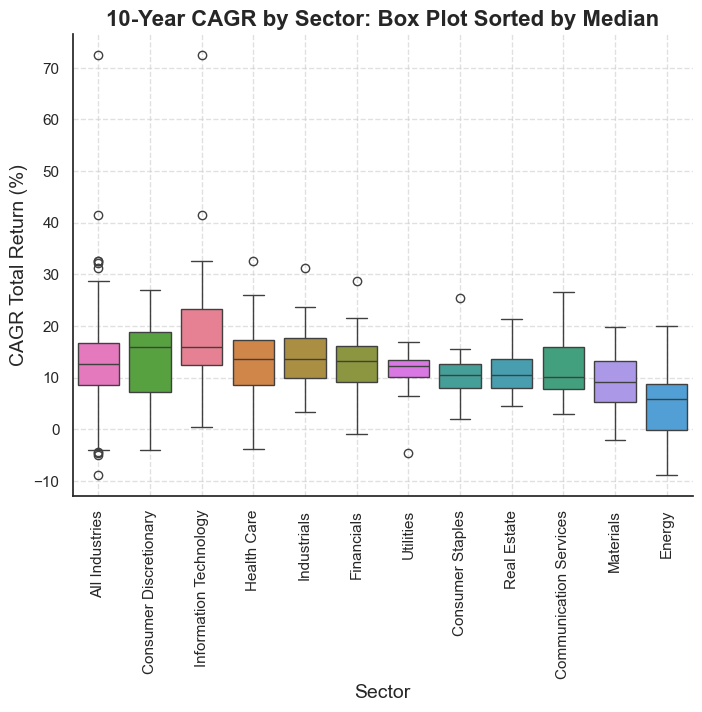

In [2494]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a copy of the dataset to include "All Industries"
df["Sector_All_Industries"] = "All Industries"
df_all_industries = df_10y.copy()  
df_all_industries["Sector"] = df_all_industries["Sector_All_Industries"]  

df_combined = pd.concat([df_10y, df_all_industries], ignore_index=True)
sector_medians = df_combined.groupby("Sector")["CAGR_10Y_Percent"].median().sort_values(ascending=False)
sector_order = ["All Industries"] + [sector for sector in sector_medians.index if sector != "All Industries"]

plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df_combined, 
    x="Sector", 
    y="CAGR_10Y_Percent",  hue="Sector",
    showfliers=True,  # Hide outliers
    order=sector_order  # Sort by median CAGR
)
plt.xlabel("Sector", fontsize=14)
plt.ylabel("CAGR Total Return (%)", fontsize=14)
plt.title("10-Year CAGR by Sector: Box Plot Sorted by Median", fontsize=16, fontweight="bold")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.grid(True, linestyle="--", alpha=0.6)  # Add grid lines for better visibility
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Análisis de la Volatilidad con CAGR

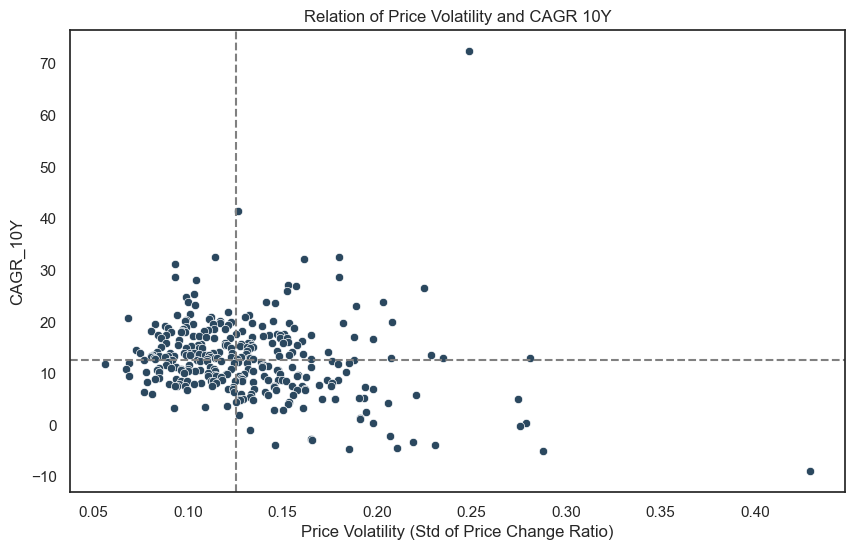

In [2106]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_10y, x='Price_Volatility', y='CAGR_10Y_Percent')
plt.axhline(y=df_10y['CAGR_10Y_Percent'].median(), color='gray', linestyle='dashed', label="Mediana CAGR")
plt.axvline(x=df_10y['Price_Volatility'].median(), color='gray', linestyle='dashed', label="Mediana Volatilidad")
plt.title("Relation of Price Volatility and CAGR 10Y")
plt.xlabel("Price Volatility (Std of Price Change Ratio)")
plt.ylabel("CAGR_10Y")
plt.show()


In [1602]:
df_10y['Price_Volatility'].describe()

count    311.000000
mean       0.132407
std        0.043593
min        0.056241
25%        0.101339
50%        0.125458
75%        0.152563
max        0.428882
Name: Price_Volatility, dtype: float64

Clasificación de la Volatilidad**  
Para facilitar el análisis de la relación entre volatilidad y rentabilidad, se segmentaron las empresas en cinco categorías en función de su **volatilidad trimestral** (`Price_Volatility`), utilizando los siguientes umbrales:  

| **Volatilidad Trimestral (`Price_Volatility`)** | **Categoría** |
|---------------------------------|----------------|
| < **10%** (≈ < 20% anual) | Muy Baja (`Very Low`) |
| 10–13% (≈ 20–26% anual) | Baja (`Low`) |
| 13–16% (≈ 26–32% anual) | Media (`Medium`) |
| 16–22% (≈ 32–44% anual) | Alta (`High`) |
| > 22% (≈ > 44% anual) | Muy Alta (`Very High`) |

### Relación entre Volatilidad y Crecimiento a Largo Plazo

C:\Users\lasso\AppData\Local\Temp\ipykernel_17744\3964037851.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_stats = df_10y.groupby('Volatility_Bin')['CAGR_10Y_Percent'].describe()
C:\Users\lasso\AppData\Local\Temp\ipykernel_17744\3964037851.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_10y, x='Volatility_Bin', y='CAGR_10Y_Percent', palette="coolwarm")


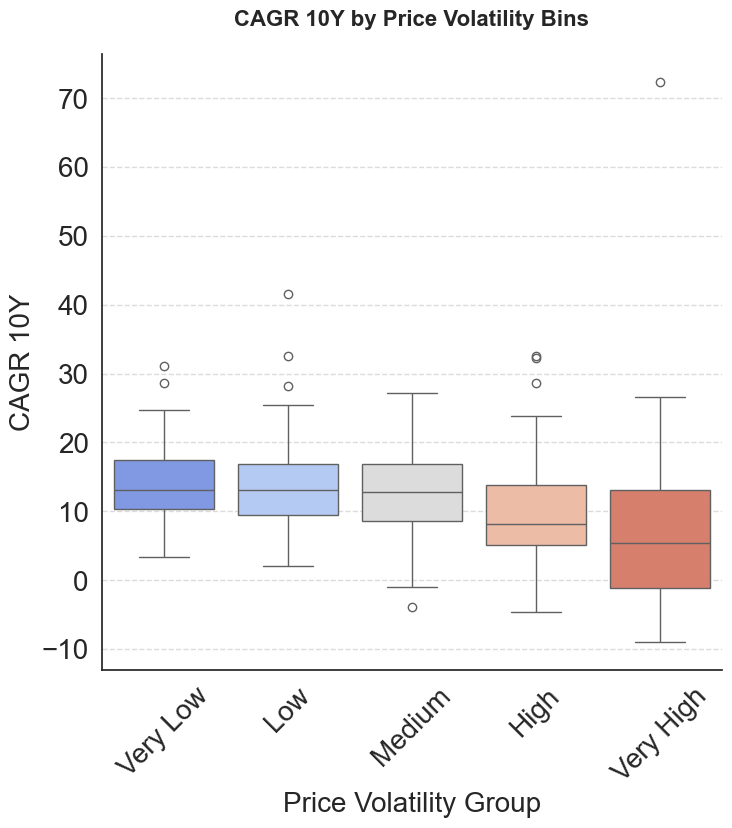

In [3015]:
grouped_stats = df_10y.groupby('Volatility_Bin')['CAGR_10Y_Percent'].describe()
plt.figure(figsize=(8, 8))
sns.boxplot(data=df_10y, x='Volatility_Bin', y='CAGR_10Y_Percent', palette="coolwarm")
plt.title("CAGR 10Y by Price Volatility Bins",  pad=20, fontsize=16, fontweight='bold')
plt.xlabel("Price Volatility Group", fontsize=20)
plt.ylabel("CAGR 10Y", fontsize=20)
plt.xticks(rotation=45, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Los datos muestran una **correlación inversa entre la volatilidad y el CAGR promedio a 10 años**.  

- Las empresas con **volatilidad muy baja o baja** obtienen en promedio un crecimiento compuesto anual superior al 13%.  
- En contraste, las empresas con **volatilidad alta o muy alta** muestran menor rendimiento promedio y una mayor dispersión de los datos, con casos extremos de rendimientos negativos.  
- Sin embargo, el segmento de **volatilidad muy alta** tiene una gran variabilidad, con algunas empresas alcanzando hasta un 72% de CAGR. Esto sugiere la presencia de compañías de alto crecimiento pero también de alto riesgo.  

Estos resultados respaldan la hipótesis de que la inversión en **empresas de baja volatilidad tiende a generar retornos más estables y consistentes a largo plazo**, en línea con los principios de inversión de Warren Buffett. No obstante, existe un subconjunto de empresas altamente volátiles que pueden ofrecer rendimientos excepcionales, aunque con un mayor riesgo asociado.  


### By Sector  


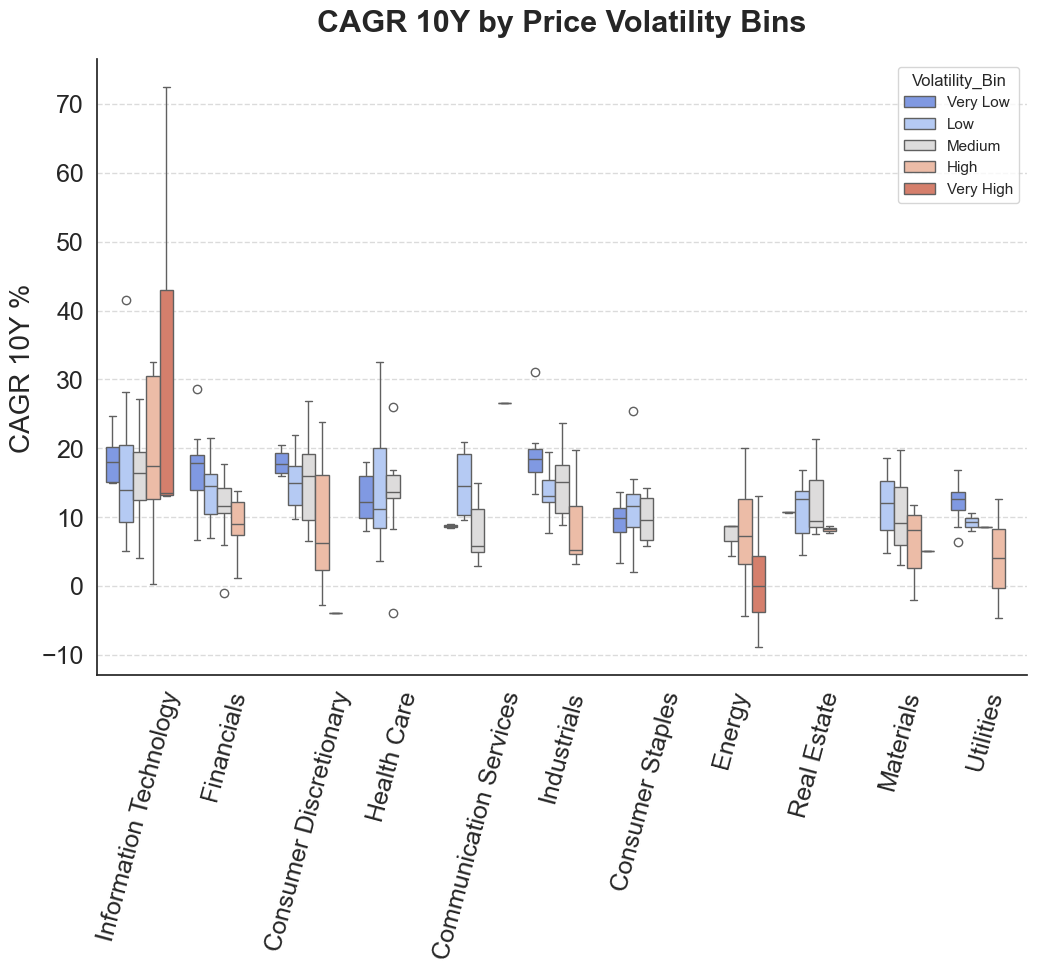

In [3021]:
plt.figure(figsize=(12, 8))
#sector_order = df_10y.groupby('Sector')['CAGR_10Y_Percent'].mean().sort_values(ascending=False).index
sns.boxplot(data=df_10y, x='Sector', y='CAGR_10Y_Percent', hue='Volatility_Bin', 
            palette="coolwarm", order=sector_order)
#sns.boxplot(data=df_10y, x='Sector', y='CAGR_10Y_Percent', hue='Volatility_Bin', palette="coolwarm")
plt.title("CAGR 10Y by Price Volatility Bins",  fontsize=22, fontweight='bold', pad=20)
plt.ylabel("CAGR 10Y %", fontsize=20)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(rotation=0, fontsize=18)
plt.xlabel("")
plt.xticks(rotation=75)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

## Extra

### Violin plot for Dividend Yield vs. CAGR_10Y (if dividend yield is important)

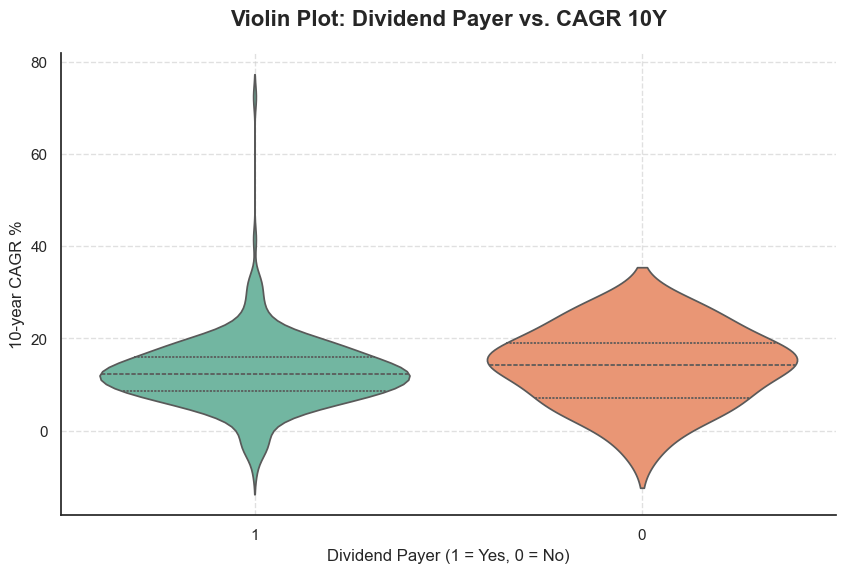

In [2599]:
# Visualize the difference in CAGR between dividend-paying and non-dividend-paying companies
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df_10y, 
    x='Dividend_Payer',  
    y='CAGR_10Y_Percent',
    hue='Dividend_Payer', 
    palette='Set2', order=[1, 0], 
    legend=False , inner="quart"
)
plt.xlabel("Dividend Payer (1 = Yes, 0 = No)")
plt.ylabel("10-year CAGR %")
plt.title("Violin Plot: Dividend Payer vs. CAGR 10Y", fontsize=16, fontweight='bold', pad=20)
plt.grid(True, linestyle='--', alpha=0.6)  
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()


### CAGR Total Return by Sector and Dividend Payer Status

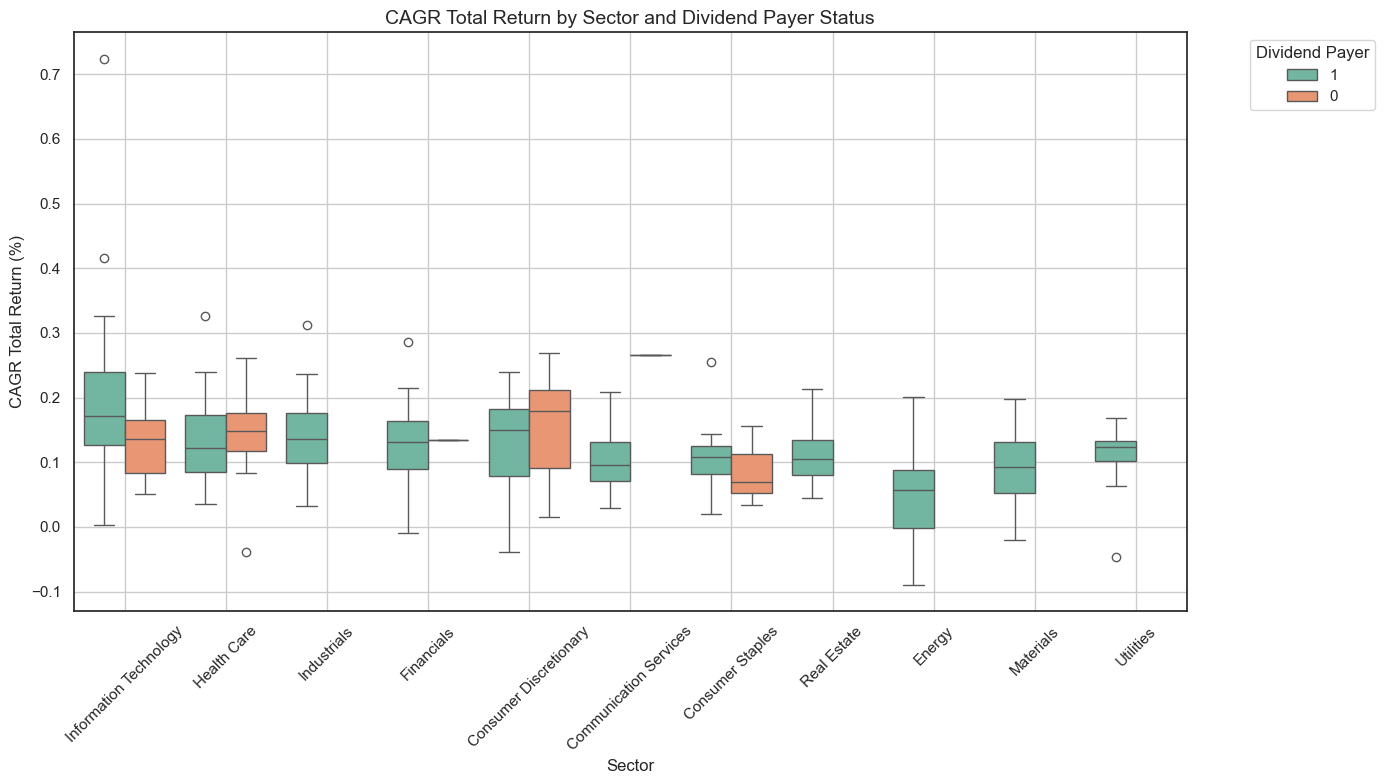

In [2601]:
# Create Boxplot comparing CAGR Total Return by Sector and Dividend Payer status
plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_10y, 
    x='Sector', 
    y='CAGR_10Y', 
    hue='Dividend_Payer', 
    palette='Set2'
)

plt.title('CAGR Total Return by Sector and Dividend Payer Status', fontsize=14)
plt.xlabel('Sector', fontsize=12)
plt.ylabel('CAGR Total Return (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Dividend Payer", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


## Correlation study

### 5Y

         CAGR_5Y  PE_Ratio  Debt_to_Equity_Ratio  Return_on_Equity  \
CAGR_5Y      1.0  0.060854             -0.057709          0.111756   

         Value_Investing  Dividend_Payer  PE_vs_Industry  Sector_Encoded  
CAGR_5Y         0.047048         0.00694        0.034623        0.058651  


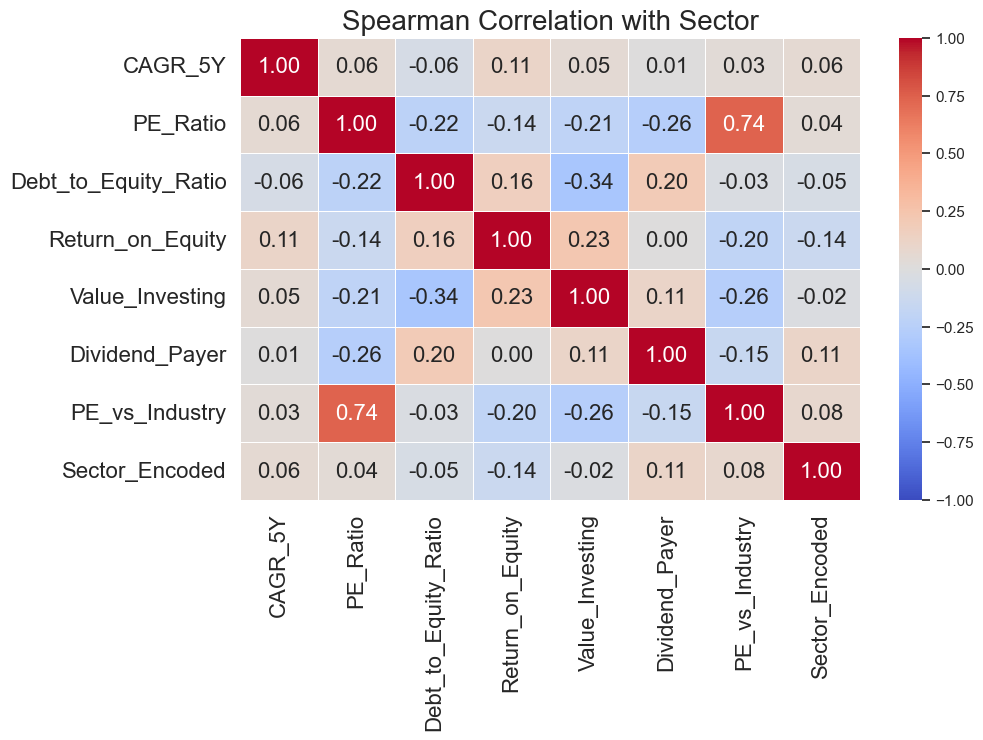

In [2987]:
df_5Y_corr = df_5Y[(df_5Y['PE_Ratio'] > 0)].copy()
df_5Y_corr.loc[:, 'Sector_Encoded'] = LabelEncoder().fit_transform(df_5Y_corr['Sector'])
df_5Y_corr.to_csv("df_5Y_corr.csv", index=False)

selected_features = ['CAGR_5Y', 'PE_Ratio', 'Debt_to_Equity_Ratio', 'Return_on_Equity', 'Value_Investing', 'Dividend_Payer', 'PE_vs_Industry']
df_corr_5Y = df_5Y_corr[selected_features + ['Sector_Encoded']]

# Spearman
spearman_corr = df_corr_5Y.corr(method='spearman')
print(spearman_corr.head(1))
plt.figure(figsize=(10, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, 
            annot_kws={"size": 16})  
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.title("Spearman Correlation with Sector", fontsize=20)  
plt.show()


In [2283]:
# Get unique sector names
sector_names = df_5Y_corr['Sector'].unique()
print(sector_names)

['Health Care' 'Information Technology' 'Consumer Staples' 'Industrials'
 'Utilities' 'Financials' 'Real Estate' 'Consumer Discretionary' 'Energy'
 'Materials' 'Communication Services']


### 5Y by Ticker

In [2362]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, mannwhitneyu

# Data filtering
df_filtered = df_5Y[(df_5Y['PE_Ratio'] > 0)].copy()

# Get unique tickers
tickers = df_filtered['Ticker'].unique()

# Dictionary to store results
correlation_results = []
u_test_results = []

# Loop through tickers
for ticker in tickers:
    df_ticker = df_filtered[df_filtered['Ticker'] == ticker]
    
    if len(df_ticker) > 5:  # Minimum data points for correlation
        # Spearman correlation
        spearman_pe, sp_pe = spearmanr(df_ticker['PE_Ratio'], df_ticker['CAGR_5Y'])
        spearman_roe, sp_roe = spearmanr(df_ticker['Return_on_Equity'], df_ticker['CAGR_5Y'])
        spearman_de, sp_de = spearmanr(df_ticker['Debt_to_Equity_Ratio'], df_ticker['CAGR_5Y'])

        correlation_results.append({
            'Ticker': ticker,
            'Spearman_PE': spearman_pe, 'Pval_SPE': sp_pe,
            'Spearman_ROE': spearman_roe, 'Pval_SROE': sp_roe,
            'Spearman_DE': spearman_de, 'Pval_SDE': sp_de
        })

        # U-Test: Divide into groups and compare CAGR_5Y
        for metric, threshold_low, threshold_high in [('PE_Ratio', 15, 25), 
                                                      ('Return_on_Equity', 0.1, 0.2), 
                                                      ('Debt_to_Equity_Ratio', 1, 2)]:
            group_low = df_ticker[df_ticker[metric] < threshold_low]['CAGR_5Y']
            group_high = df_ticker[df_ticker[metric] > threshold_high]['CAGR_5Y']
            
            if len(group_low) > 3 and len(group_high) > 3:
                u_stat, p_value = mannwhitneyu(group_low, group_high, alternative='two-sided')
                u_test_results.append({
                    'Ticker': ticker, 'Metric': metric,
                    'U_stat': u_stat, 'P_value': p_value,
                    'Mean_Low_Group': group_low.mean(),
                    'Mean_High_Group': group_high.mean()
                })

# Convert results to DataFrame
df_corr = pd.DataFrame(correlation_results)
df_u_test = pd.DataFrame(u_test_results)

# Create categories for Spearman correlation ranges
bins_1 = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
labels_1 = ['1 Strong Negative', '2 Moderate Negative', '3 Weak Negative', 
            '4 Slightly Negative', '5 Slightly Positive', '6 Weak Positive', 
            '7 Moderate Positive', '8 Strong Positive']  # Labels for correlation

df_corr['Correlation_Range'] = pd.cut(df_corr['Spearman_PE'], bins=bins_1, labels=labels_1, include_lowest=True)

# Sort DataFrame by correlation range labels
df_corr['Correlation_Range'] = pd.Categorical(df_corr['Correlation_Range'], categories=labels_1, ordered=True)
df_corr = df_corr.sort_values(by='Correlation_Range')



# Create the final result table
result = pd.DataFrame({
    'Percentage': correlation_distribution
})

# Sort the result by 'Correlation_Range'
result_sorted = result.sort_values(by='Correlation_Range')

# Output the sorted result
print(result_sorted)

# Additional output for significant negative correlations
negative_pe = df_corr[(df_corr['Spearman_PE'] < 0) & (df_corr['Pval_SPE'] < 0.05)]
positive_roe = df_corr[(df_corr['Spearman_ROE'] > 0) & (df_corr['Pval_SROE'] < 0.05)]
negative_de = df_corr[(df_corr['Spearman_DE'] < 0) & (df_corr['Pval_SDE'] < 0.05)]

print(f"Percentage of tickers with significant negative correlation (P/E): {len(negative_pe) / len(df_corr):.2%}")
print(f"Percentage of tickers with significant positive correlation (ROE): {len(positive_roe) / len(df_corr):.2%}")
print(f"Percentage of tickers with significant negative correlation (D/E): {len(negative_de) / len(df_corr):.2%}")

# U-test results
significant_u_tests = df_u_test[df_u_test['P_value'] < 0.05]
print(f"Significant U-tests count: {len(significant_u_tests)}")


                     Percentage
Correlation_Range              
1 Strong Negative     10.402685
2 Moderate Negative   18.791946
3 Weak Negative       26.845638
4 Slightly Negative   18.456376
5 Slightly Positive   14.765101
6 Weak Positive        9.060403
7 Moderate Positive    1.006711
8 Strong Positive      0.671141
Percentage of tickers with significant negative correlation (P/E): 35.18%
Percentage of tickers with significant positive correlation (ROE): 11.73%
Percentage of tickers with significant negative correlation (D/E): 17.26%
Significant U-tests count: 31


**Análisis de las métricas de correlación en la rentabilidad de las acciones**  

**Resumen**  
Este estudio analiza la relación entre diversas métricas financieras y la rentabilidad de las acciones, con el objetivo de identificar patrones de correlación entre el crecimiento a largo plazo de las empresas y sus indicadores fundamentales. Se aplicaron pruebas de correlación de Spearman y pruebas U de Mann-Whitney para evaluar la significancia estadística de estas relaciones.  

**Resultados**  
Los resultados de la correlación de Spearman entre la rentabilidad de las acciones (CAGR_5Y) y las métricas fundamentales revelan diferencias en la fuerza y dirección de las asociaciones:  

| **Rango de Correlación**  | **Porcentaje de Tickers (%)** |  
|---------------------------|------------------------------|  
| Fuerte negativa           | 10.40%                       |  
| Moderada negativa         | 18.79%                       |  
| Débil negativa            | 26.85%                       |  
| Ligeramente negativa      | 18.46%                       |  
| Ligeramente positiva      | 14.77%                       |  
| Débil positiva            | 9.06%                        |  
| Moderada positiva         | 1.01%                        |  
| Fuerte positiva           | 0.67%                        |  

En particular, se destacan los siguientes hallazgos clave:  

- **El 35.18% de los tickers muestran una correlación negativa y estadísticamente significativa entre el P/E y la rentabilidad (CAGR_5Y)**, lo que sugiere que empresas con múltiplos P/E más altos tienden a presentar menores tasas de crecimiento a largo plazo.  
- **El 11.73% de los tickers presentan una correlación positiva y significativa entre el ROE y la rentabilidad**, lo que indica que un mayor retorno sobre el patrimonio (ROE) podría estar asociado con un mayor crecimiento de las acciones.  
- **El 17.26% de los tickers tienen una correlación negativa y significativa entre el D/E y la rentabilidad**, lo que sugiere que un alto nivel de endeudamiento puede afectar negativamente el rendimiento a largo plazo de las acciones.  

**Prueba U de Mann-Whitney**  
Para complementar el análisis de correlación, se realizaron pruebas U de Mann-Whitney para evaluar si existen diferencias significativas en el crecimiento de las acciones entre empresas con métricas financieras extremas (altas y bajas). Se identificaron **31 pruebas significativas**, lo que refuerza la validez de las correlaciones observadas.  

**Conclusión**  
Los resultados sugieren que ciertos indicadores financieros, en particular el P/E, el ROE y el D/E, presentan relaciones significativas con la rentabilidad de las acciones. La fuerte correlación negativa entre el P/E y el crecimiento de las acciones plantea interrogantes sobre el uso de este múltiplo como predictor de rentabilidad futura, mientras que la relación positiva entre el ROE y la rentabilidad respalda su relevancia como métrica clave para los inversores. Futuras investigaciones podrían explorar estas relaciones en diferentes sectores y períodos de tiempo para profundizar en la robustez de estos hallazgos.

Top 10 by CAGR_10Y (sorted by CAGR_10Y)
                         Spearman_PE  Spearman_ROE  Spearman_DE
Security                                                       
Nvidia                     -0.418408     -0.534726     0.194405
Broadcom                   -0.153767      0.141383     0.157976
Lilly (Eli)                -0.042105      0.428571     0.945865
Lam Research               -0.156453     -0.085263     0.140073
KLA Corporation            -0.396951      0.529080    -0.133823
Cintas                     -0.693958     -0.073970    -0.466234
Applied Materials          -0.323546      0.093168     0.006782
Progressive Corporation    -0.177866     -0.454545     0.065009
Microsoft                  -0.132693     -0.129305    -0.081333
Apple Inc.                 -0.428692      0.107849     0.220904


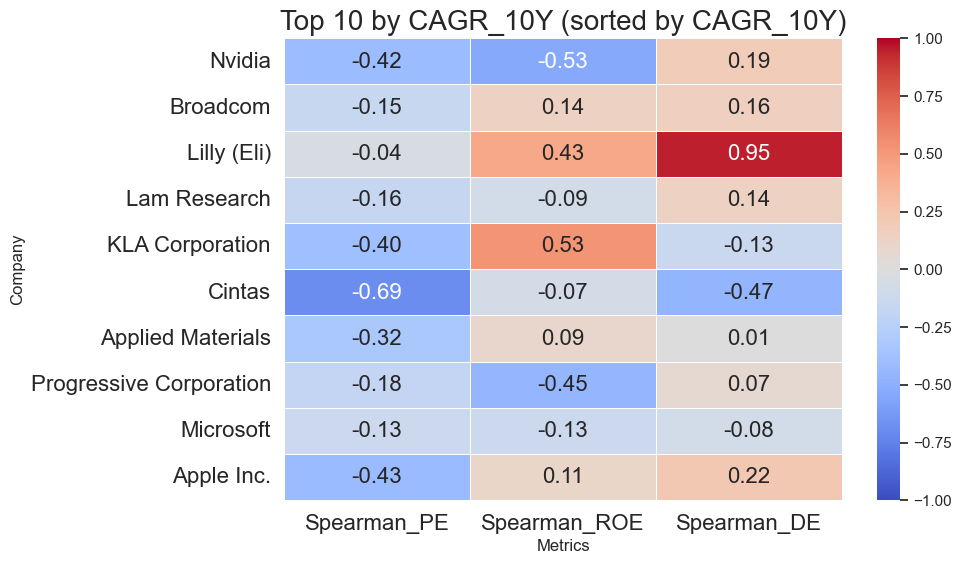

Top 10 by Dividend Yield (sorted by Dividend_Yield)
                 Spearman_PE  Spearman_ROE  Spearman_DE
Security                                               
Lam Research       -0.156453     -0.085263     0.140073
Broadcom           -0.153767      0.141383     0.157976
Altria              0.273857     -0.595709     0.218521
Cintas             -0.693958     -0.073970    -0.466234
CME Group          -0.217391     -0.773010     0.189777
Best Buy           -0.741389     -0.717674    -0.682293
AT&T                0.071711     -0.219650     0.127191
Iron Mountain       0.206494     -0.270130    -0.012987
AbbVie             -0.300960     -0.042349    -0.044620
KLA Corporation    -0.396951      0.529080    -0.133823


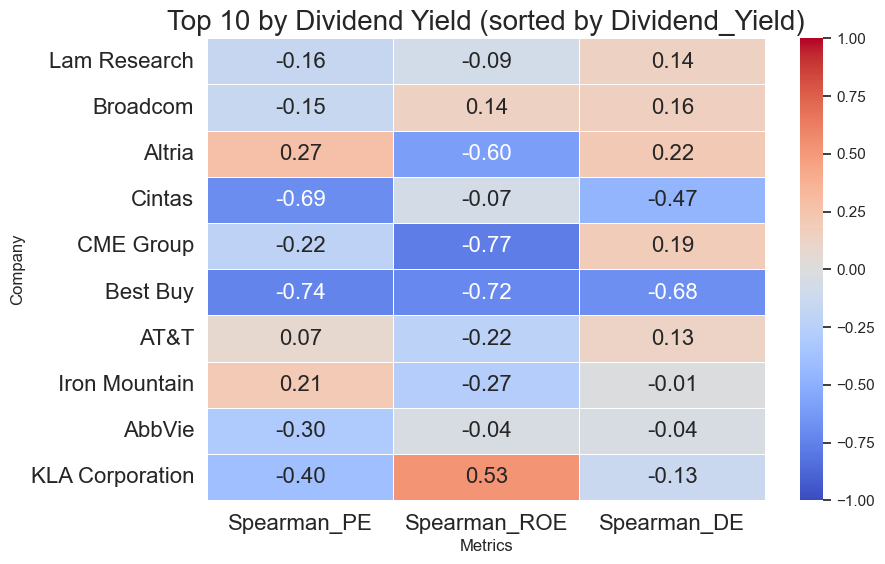

Top 10 by Price Volatility (sorted by Price_Volatility)
                      Spearman_PE  Spearman_ROE  Spearman_DE
Security                                                    
APA Corporation         -0.309091      0.427273    -0.127563
Halliburton             -0.285714     -0.197802     0.629987
First Solar             -0.118881      0.034965     0.101935
Occidental Petroleum     0.181319     -0.170330     0.511692
Devon Energy            -0.401099      0.521978     0.365888
Freeport-McMoRan        -0.027972      0.013986    -0.307692
Nvidia                  -0.418408     -0.534726     0.194405
ONEOK                   -0.415254      0.000000     0.151370
Wynn Resorts            -0.069452     -0.164314     0.202710
Seagate Technology       0.482194     -0.408244     0.346132


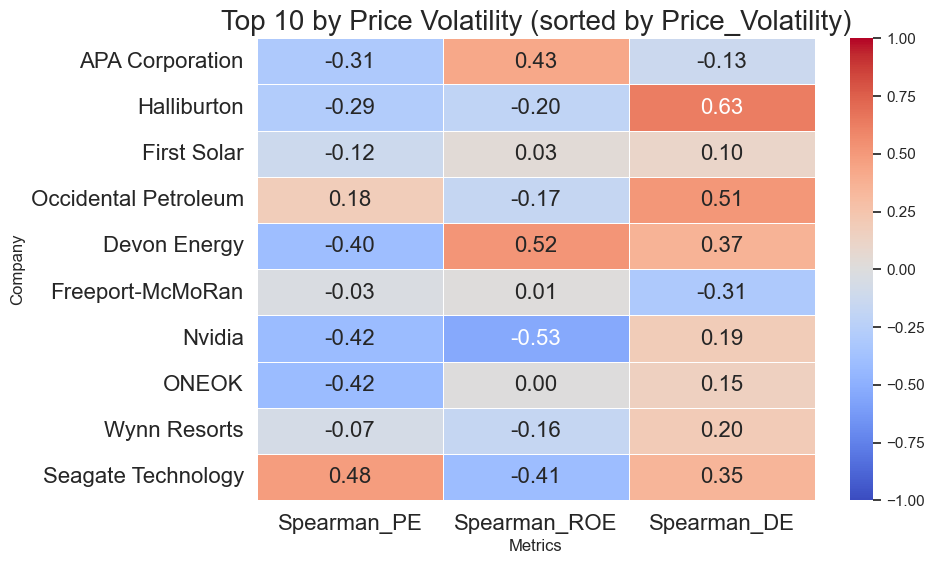

Bottom 10 by CAGR_10Y (sorted by CAGR_10Y)
                      Spearman_PE  Spearman_ROE  Spearman_DE
Security                                                    
APA Corporation         -0.309091      0.427273    -0.127563
Halliburton             -0.285714     -0.197802     0.629987
PG&E Corporation         0.091847     -0.353973    -0.436984
Schlumberger             0.395604     -0.516484     0.751032
Wynn Resorts            -0.069452     -0.164314     0.202710
Biogen                  -0.435347      0.335968     0.524471
EQT Corporation          0.636364     -0.664336    -0.851140
BorgWarner              -0.370977     -0.530209     0.399435
Carnival                 0.383399     -0.713156    -0.432618
Mosaic Company (The)     0.537668     -0.727554     0.339570


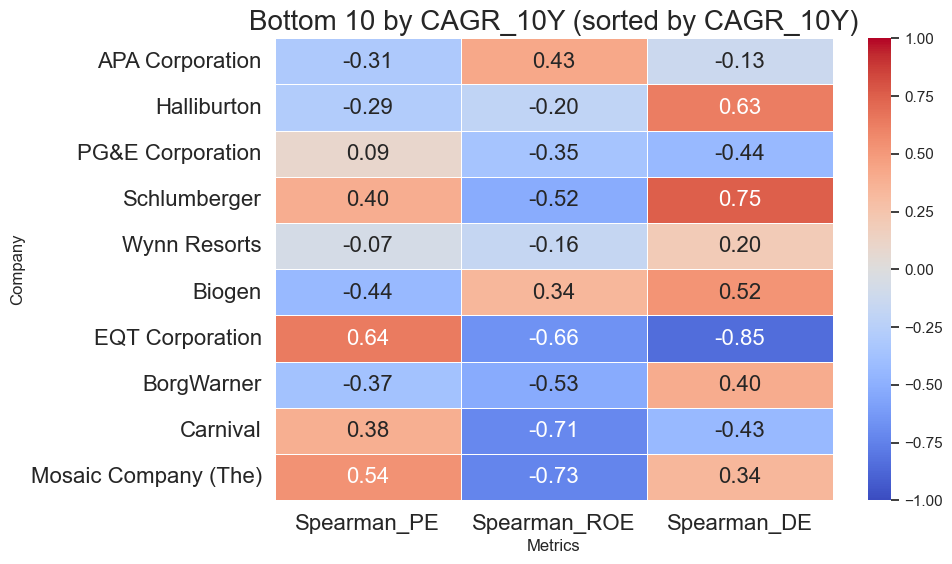

In [2991]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to select the top-10 companies based on a specific metric
def get_top_10(df, metric, ascending=False):
    top_df = df.nsmallest(10, metric) if ascending else df.nlargest(10, metric)
    return top_df[['Security', metric]].sort_values(by=metric, ascending=ascending)

# Select top-10 companies based on different metrics
top_cagr10y = get_top_10(df_10y, 'CAGR_10Y')
top_div_yield = get_top_10(df_10y, 'Dividend_Yield')
top_volatility = get_top_10(df_10y, 'Price_Volatility')
low_cagr10y = get_top_10(df_10y, 'CAGR_10Y', ascending=True)  # Bottom-10 by CAGR

# Drop existing 'Security' column in df_corr (if it exists) to avoid merge conflict
if 'Security' in df_corr.columns:
    df_corr = df_corr.drop(columns=['Security'])

# Merge Security column into df_corr
df_corr = df_corr.merge(df_10y[['Ticker', 'Security']], on='Ticker', how='left')

# Function to plot heatmap
def plot_heatmap(df_corr, selected_df, title, metric):
    selected_securities = selected_df['Security'].tolist()
    
    # Filter correlation DataFrame by selected companies
    df_heatmap = df_corr[df_corr['Security'].isin(selected_securities)]

    # Select relevant columns if they exist
    selected_columns = ['Security', 'Pearson_PE', 'Pearson_ROE', 'Pearson_DE', 'Spearman_PE', 'Spearman_ROE', 'Spearman_DE']
    
    # Ensure all columns exist before selecting
    df_heatmap = df_heatmap[[col for col in selected_columns if col in df_heatmap.columns]].set_index('Security')

    # Reorder based on the sorted metric
    df_heatmap = df_heatmap.reindex(selected_df['Security'])

    # Print heatmap data before plotting
    print(f"{title} (sorted by {metric})")
    print(df_heatmap.to_string(index=True))

    
    # Plot heatmap
    plt.figure(figsize=(9, 6))
    sns.heatmap(df_heatmap, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5, vmax=1, vmin=-1, annot_kws={"size": 16})       
    plt.xticks(fontsize=16)  
    plt.yticks(fontsize=16)  
    plt.title(f"{title} (sorted by {metric})", fontsize=20) 
    plt.xlabel("Metrics")
    plt.ylabel("Company")
    plt.xticks(rotation=0)
    plt.show()

# **Generate 4 heatmaps**
plot_heatmap(df_corr, top_cagr10y, "Top 10 by CAGR_10Y", "CAGR_10Y")
plot_heatmap(df_corr, top_div_yield, "Top 10 by Dividend Yield", "Dividend_Yield")
plot_heatmap(df_corr, top_volatility, "Top 10 by Price Volatility", "Price_Volatility")
plot_heatmap(df_corr, low_cagr10y, "Bottom 10 by CAGR_10Y", "CAGR_10Y")  # Bottom-10


Analysis:
PE Ratio vs CAGR:
The PE Ratio often reflects the market's valuation of a sector relative to its earnings. A higher PE typically suggests that investors expect higher future growth, but it could also indicate overvaluation.
Looking at your data, sectors like Information Technology (PE = 21.02) have a high CAGR (20.7%), which aligns with the general belief that high-growth sectors tend to have higher PEs. Conversely, Energy (PE = 9.02) shows the lowest CAGR (5.96%), reflecting lower growth expectations.
Debt-to-Equity Ratio vs CAGR:
A lower Debt-to-Equity Ratio generally suggests financial stability and lower risk, which is often more attractive to conservative investors. High D/E ratios, such as in Financials (D/E = 5.76), could indicate greater reliance on debt, which might amplify risks, especially in volatile market conditions.
In your data, sectors with higher D/E ratios (e.g., Financials with D/E = 5.76) generally show moderate returns, while sectors like Information Technology (D/E = 2.01) and Health Care (D/E = 2.28) have a higher CAGR, which might indicate growth despite a relatively high leverage.

### 10Y

          CAGR_10Y  PE_Ratio_Mean_  ROE_Mean  Debt_to_Equity_Mean  \
CAGR_10Y       1.0        0.062736   0.29592            -0.045078   

          Dividend_Yield  Price_Volatility  Sector_Encoded  
CAGR_10Y        0.193049         -0.231137        0.065278  


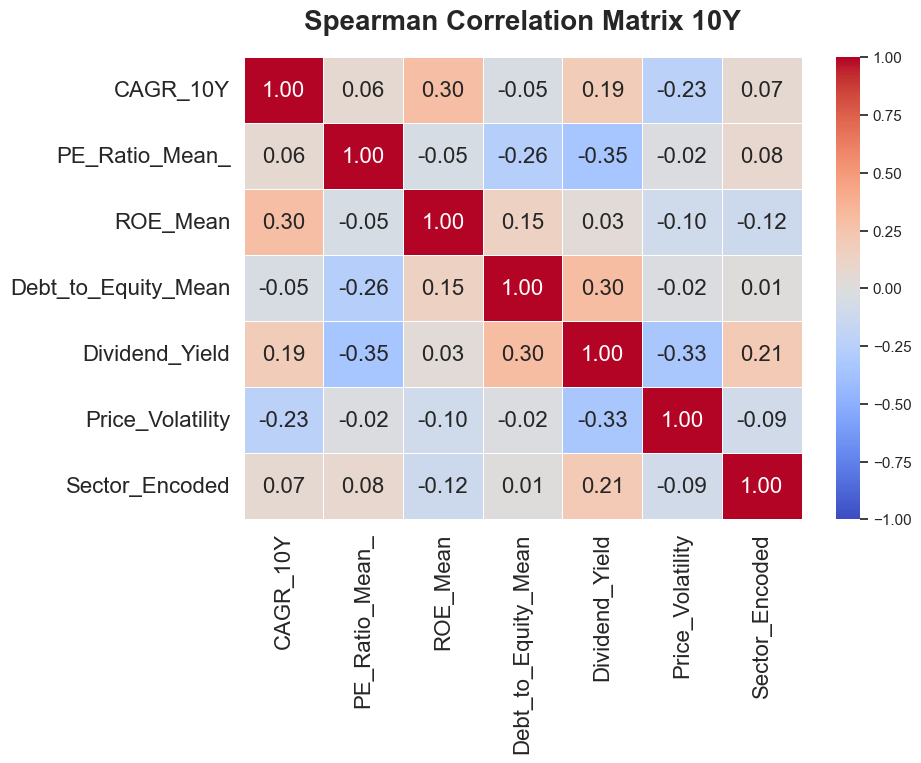

In [2999]:
label_encoder = LabelEncoder()

if 'Sector' in df_10y.columns:
    df_10y['Sector_Encoded'] = label_encoder.fit_transform(df_10y['Sector'])
else:
    print("Error: No 'Sector' column found in the DataFrame.")
cols_for_corr = ['CAGR_10Y', 'PE_Ratio_Mean_', 'ROE_Mean', 'Debt_to_Equity_Mean', 'Dividend_Yield', 'Price_Volatility', 'Sector_Encoded']

spearman_corr = df_10y[cols_for_corr].corr(method='spearman')
print(spearman_corr.head(1))

plt.figure(figsize=(9, 6))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, annot_kws={"size": 16})       
plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  
plt.title('Spearman Correlation Matrix 10Y', pad=20, fontsize=20, fontweight='bold')
plt.show()
